# Warming trend and marine heat waves of an Australian Marine Park

**What does this notebook do?** 
This notebook demonstrates how to generate and plot SST time-series for a Australian Marine Park, and to detect its warming trend and potential marine heat wave events.

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 16th, Jan, 2019

**Author:** Zhi Huang

**Import modules**

In [1]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import fiona
#from shapely import geometry
from datacube.utils import geometry
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
from datacube.helpers import write_geotiff
import pandas as pd
from datetime import datetime
import rasterio.features

**Specify a development database to connect to. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [2]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**The only product in this database is the daily ocean colour data between 2002 and 2019.**

PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]


<Figure size 432x288 with 0 Axes>

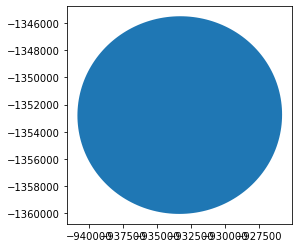

In [3]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'

#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

print(crs)
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()

plt.show()


**Note that the CRS is GDA94 Australian Albers**

In [4]:
query = {'geopolygon': geom,
         'output_crs': 'EPSG:3577',
         'resolution': (-1300,1300)
         }

**Load full time-series of SST (Sea Surface Temperature), for the Cartier Island Marine Park area, from 2002 to 2019.**

In [5]:
time1 = datetime.now()
data = dc.load(product='modis_oc_1d', measurements=(['sst']), **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:14:27.532756 to finish


**create a mask for the area covered by the AMP polygon**

In [6]:
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs) for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
data = data.where(mask)

**Mask the nodata (-999) as 'nan'**

In [7]:
data = mask_invalid_data(data)

In [8]:
data

<xarray.Dataset>
Dimensions:  (time: 6214, x: 12, y: 13)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * y        (y) float64 -1.345e+06 -1.346e+06 ... -1.359e+06 -1.36e+06
  * x        (x) float64 -9.406e+05 -9.392e+05 ... -9.276e+05 -9.262e+05
Data variables:
    sst      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

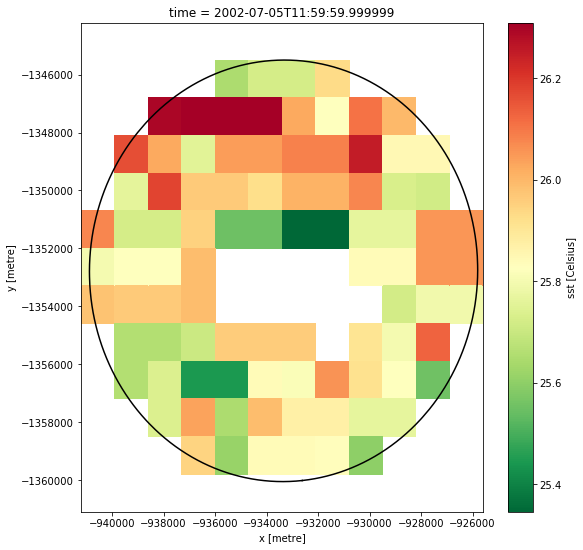

In [9]:
#plot polygon to check it looks ok

import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(9,9))

for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
data.sst[1].plot(cmap='RdYlGn_r')

##### **testDF contains all SST data loaded: 156 (12 x 13) locations (as columns) with 6214 daily time-series (as rows)**

In [10]:
testDF = pd.DataFrame()
latlonDF = pd.DataFrame()
latList = []
lonList = []
idList = []
latIndex = 0
lonIndex = 0
id = 1
while latIndex < data.y.size:
    while lonIndex < data.x.size:
        lat = data.sst[:,latIndex,lonIndex].y.values
        lon = data.sst[:,latIndex,lonIndex].x.values
        latList.append(lat)
        lonList.append(lon)
        idList.append(id)
        sstData = data.sst[:,latIndex,lonIndex].values
        testDF[id] = sstData
        id += 1
        lonIndex += 1
    latIndex += 1
    lonIndex = 0
dateList = []
i = 0
while i < data.time.size:
    date = str(data.time[i].data)[:4] + str(data.time[i].data)[5:7] + str(data.time[i].data)[8:10]
    dateList.append(date)
    i += 1
testDF['date'] = dateList
testDF.set_index('date', inplace=True)
latlonDF['id'] = idList
latlonDF['lat'] = latList
latlonDF['lon'] = lonList
latlonDF.set_index('id', inplace=True)

In [11]:
testDF.tail(10)

,1,2,3,4,5,6,7,8,9,10,...,147,148,149,150,151,152,153,154,155,156
date,,,,,,,,,,,,,,,,,,,,,
20190713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**The pad function interpolate over missing data in a time series. Courtesy of Hobday's marine heat waves codes**

In [11]:
import numpy as np
import scipy.ndimage as ndimage
def pad(data, maxPadLength=False):
    '''

    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data	     Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015

    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded


**The four Feb 29 dates from the leap years are drop to facilitate the MHW analysis**

In [12]:
testDF1 = testDF.drop(['20040229','20080229','20120229','20160229'])

**Calculate the dayofyear for each date, and add it to the DataFrame. 
Note that the removal of the Feb 29 dates results in the matching of the dayofyear across years**

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
i = 0
dayofyears = []

while i < testDF1.index.size:
    date = testDF1.index[i]
    year = date[:4]
    ## remove the four Feb 29 in the leap years from the collection
   
    ## calculate dayofyear
    ## because the 4 Feb-29 dates have been removed, the dayofyears for all years are now matched
    dayofyear = datetime.strptime(date,'%Y%m%d').timetuple().tm_yday
    if (year == '2004') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2008') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2012') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2016') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    print(date)
    print(dayofyear)

    dayofyears.append(dayofyear)

    i = i + 1
testDF1['dayofyear']=dayofyears



20020704
185
20020705
186
20020706
187
20020707
188
20020708
189
20020709
190
20020710
191
20020711
192
20020712
193
20020713
194
20020714
195
20020715
196
20020716
197
20020717
198
20020718
199
20020719
200
20020720
201
20020721
202
20020722
203
20020723
204
20020724
205
20020725
206
20020726
207
20020727
208
20020728
209
20020729
210
20020807
219
20020808
220
20020809
221
20020810
222
20020811
223
20020812
224
20020813
225
20020814
226
20020815
227
20020816
228
20020817
229
20020818
230
20020819
231
20020820
232
20020821
233
20020822
234
20020823
235
20020824
236
20020825
237
20020826
238
20020827
239
20020828
240
20020829
241
20020830
242
20020831
243
20020901
244
20020902
245
20020903
246
20020904
247
20020905
248
20020906
249
20020907
250
20020908
251
20020909
252
20020910
253
20020911
254
20020912
255
20020913
256
20020914
257
20020915
258
20020916
259
20020917
260
20020918
261
20020919
262
20020920
263
20020921
264
20020922
265
20020923
266
20020924
267
20020925
268
20020926
269

20040620
171
20040621
172
20040622
173
20040623
174
20040624
175
20040625
176
20040626
177
20040627
178
20040628
179
20040629
180
20040630
181
20040701
182
20040702
183
20040703
184
20040704
185
20040705
186
20040706
187
20040707
188
20040708
189
20040709
190
20040710
191
20040711
192
20040712
193
20040713
194
20040714
195
20040715
196
20040716
197
20040717
198
20040718
199
20040719
200
20040720
201
20040721
202
20040722
203
20040723
204
20040724
205
20040725
206
20040726
207
20040727
208
20040728
209
20040729
210
20040730
211
20040731
212
20040801
213
20040802
214
20040803
215
20040804
216
20040805
217
20040806
218
20040807
219
20040808
220
20040809
221
20040810
222
20040811
223
20040812
224
20040813
225
20040814
226
20040815
227
20040816
228
20040817
229
20040818
230
20040819
231
20040820
232
20040821
233
20040822
234
20040823
235
20040824
236
20040825
237
20040826
238
20040827
239
20040828
240
20040829
241
20040830
242
20040831
243
20040901
244
20040902
245
20040903
246
20040904
247

321
20071118
322
20071119
323
20071120
324
20071121
325
20071122
326
20071123
327
20071124
328
20071125
329
20071126
330
20071127
331
20071128
332
20071129
333
20071130
334
20071201
335
20071203
337
20071204
338
20071205
339
20071206
340
20071207
341
20071208
342
20071209
343
20071210
344
20071211
345
20071212
346
20071213
347
20071214
348
20071215
349
20071216
350
20071217
351
20071218
352
20071219
353
20071220
354
20071221
355
20071222
356
20071223
357
20071224
358
20071225
359
20071226
360
20071227
361
20071228
362
20071229
363
20071230
364
20071231
365
20080101
1
20080102
2
20080103
3
20080104
4
20080105
5
20080106
6
20080107
7
20080108
8
20080109
9
20080110
10
20080111
11
20080112
12
20080113
13
20080114
14
20080115
15
20080116
16
20080117
17
20080118
18
20080119
19
20080120
20
20080121
21
20080122
22
20080123
23
20080124
24
20080125
25
20080126
26
20080127
27
20080128
28
20080129
29
20080130
30
20080131
31
20080201
32
20080202
33
20080203
34
20080204
35
20080205
36
20080206
37
20

20091009
282
20091010
283
20091011
284
20091012
285
20091013
286
20091014
287
20091015
288
20091016
289
20091017
290
20091018
291
20091019
292
20091020
293
20091021
294
20091022
295
20091023
296
20091024
297
20091025
298
20091026
299
20091027
300
20091028
301
20091029
302
20091030
303
20091031
304
20091101
305
20091102
306
20091103
307
20091104
308
20091105
309
20091106
310
20091107
311
20091108
312
20091109
313
20091110
314
20091111
315
20091112
316
20091113
317
20091114
318
20091115
319
20091116
320
20091117
321
20091118
322
20091119
323
20091120
324
20091121
325
20091122
326
20091123
327
20091124
328
20091125
329
20091126
330
20091127
331
20091128
332
20091129
333
20091130
334
20091201
335
20091202
336
20091203
337
20091204
338
20091205
339
20091206
340
20091207
341
20091208
342
20091209
343
20091210
344
20091211
345
20091212
346
20091213
347
20091214
348
20091215
349
20091216
350
20091217
351
20091218
352
20091219
353
20091220
354
20091221
355
20091222
356
20091223
357
20091224
358

20121228
362
20121229
363
20121230
364
20121231
365
20130101
1
20130102
2
20130103
3
20130104
4
20130105
5
20130106
6
20130107
7
20130108
8
20130109
9
20130110
10
20130111
11
20130112
12
20130113
13
20130114
14
20130115
15
20130116
16
20130117
17
20130118
18
20130119
19
20130120
20
20130121
21
20130122
22
20130123
23
20130124
24
20130125
25
20130126
26
20130127
27
20130128
28
20130129
29
20130130
30
20130131
31
20130201
32
20130202
33
20130203
34
20130204
35
20130205
36
20130206
37
20130207
38
20130208
39
20130209
40
20130210
41
20130211
42
20130212
43
20130213
44
20130214
45
20130215
46
20130216
47
20130217
48
20130218
49
20130219
50
20130220
51
20130221
52
20130222
53
20130223
54
20130224
55
20130225
56
20130226
57
20130227
58
20130228
59
20130301
60
20130302
61
20130303
62
20130304
63
20130305
64
20130306
65
20130307
66
20130308
67
20130309
68
20130310
69
20130311
70
20130312
71
20130313
72
20130314
73
20130315
74
20130316
75
20130317
76
20130318
77
20130319
78
20130320
79
20130321


197
20150717
198
20150718
199
20150719
200
20150720
201
20150721
202
20150722
203
20150723
204
20150724
205
20150725
206
20150726
207
20150727
208
20150728
209
20150729
210
20150730
211
20150731
212
20150801
213
20150802
214
20150803
215
20150804
216
20150805
217
20150806
218
20150807
219
20150808
220
20150809
221
20150810
222
20150811
223
20150812
224
20150813
225
20150814
226
20150815
227
20150816
228
20150817
229
20150818
230
20150819
231
20150820
232
20150821
233
20150822
234
20150823
235
20150824
236
20150825
237
20150826
238
20150827
239
20150828
240
20150829
241
20150830
242
20150831
243
20150901
244
20150902
245
20150903
246
20150904
247
20150905
248
20150906
249
20150907
250
20150908
251
20150909
252
20150910
253
20150911
254
20150912
255
20150913
256
20150914
257
20150915
258
20150916
259
20150917
260
20150918
261
20150919
262
20150920
263
20150921
264
20150922
265
20150923
266
20150924
267
20150925
268
20150926
269
20150927
270
20150928
271
20150929
272
20150930
273
20151001

20170622
173
20170623
174
20170624
175
20170625
176
20170626
177
20170627
178
20170628
179
20170629
180
20170630
181
20170701
182
20170702
183
20170703
184
20170704
185
20170705
186
20170706
187
20170707
188
20170708
189
20170709
190
20170710
191
20170711
192
20170712
193
20170713
194
20170714
195
20170715
196
20170716
197
20170717
198
20170718
199
20170719
200
20170720
201
20170721
202
20170722
203
20170723
204
20170724
205
20170725
206
20170726
207
20170727
208
20170728
209
20170729
210
20170730
211
20170731
212
20170801
213
20170802
214
20170803
215
20170804
216
20170805
217
20170806
218
20170807
219
20170808
220
20170809
221
20170810
222
20170811
223
20170812
224
20170813
225
20170814
226
20170815
227
20170816
228
20170817
229
20170818
230
20170819
231
20170820
232
20170821
233
20170822
234
20170823
235
20170824
236
20170825
237
20170826
238
20170827
239
20170828
240
20170829
241
20170830
242
20170831
243
20170901
244
20170902
245
20170903
246
20170904
247
20170905
248
20170906
249

192
20190712
193
20190713
194
20190714
195
20190715
196
20190716
197
20190717
198
20190718
199
20190719
200
20190720
201
20190721
202
20190722
203


In [14]:
testDF1.shape

(6210, 157)

**The testIDF1 is generated from testDF1 after applying the interpolation (pad) function**

In [15]:
testIDF1 = pd.DataFrame()
interpolatedSSTList = []

for i in testDF1.columns:
    sst = testDF1[i].values
    if np.isnan(sst).all():
        print(i, 'no data')
        latlonDF = latlonDF.drop(i, axis=0)
    else:
        interpolatedSST = pad(sst,maxPadLength=2)
        testIDF1[i] = interpolatedSST
    
testIDF1['date'] = testDF1.index
testIDF1['dayofyear'] = testDF1['dayofyear'].values
testIDF1.set_index('date', inplace=True)

1 no data
2 no data
3 no data
4 no data
5 no data
6 no data
7 no data
8 no data
9 no data
10 no data
11 no data
12 no data
13 no data
14 no data
15 no data
16 no data
21 no data
22 no data
23 no data
24 no data
25 no data
26 no data
35 no data
36 no data
37 no data
48 no data
49 no data
60 no data
97 no data
108 no data
109 no data
120 no data
121 no data
122 no data
131 no data
132 no data
133 no data
134 no data
135 no data
142 no data
143 no data
144 no data
145 no data
146 no data
147 no data
148 no data
149 no data
150 no data
151 no data
152 no data
153 no data
154 no data
155 no data
156 no data


In [16]:
testIDF1.shape

(6210, 103)

In [20]:
x = testIDF1.loc['20020704']
# counting the number of nan in x
np.count_nonzero(np.isnan(x))

2

**More efficient codes to calculate the 90 percentile climatology data with 11-days window and smooth it with 31-days running average**

In [17]:
# 90th percentile with 11-days window
# this one takes much shorter to complete, as it only runs for one year cycle
nintyDF2 = pd.DataFrame()

print('start', datetime.now())
for i in testIDF1.columns:
    print(str(i))
    nintyList = []
    dayofyearList = []
    for date in testIDF1.loc['20030101':'20031231'].index:
        dayofyear = testIDF1.dayofyear.loc[date]
        if np.isin(dayofyear, dayofyearList):
            break
        else:
            dayofyearList.append(dayofyear)
        if dayofyear == 1:
            dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
        elif dayofyear == 2:
            dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
        elif dayofyear == 3:
            dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
        elif dayofyear == 4:
            dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
        elif dayofyear == 5:
            dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
        elif dayofyear == 365:
            dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
        elif dayofyear == 364:
            dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
        elif dayofyear == 363:
            dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
        elif dayofyear == 362:
            dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
        elif dayofyear == 361:
            dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
        else:
            dayofyears = np.arange(dayofyear-5,dayofyear+6,1)
        
        #print(dayofyears)
        x = testIDF1[testIDF1.dayofyear.isin(dayofyears)][i]
        x_90 = x.quantile(0.9)
        nintyList.append(x_90)
    nintyDF2[i] = nintyList
   
#nintyDF2['date'] = testDF1.index
nintyDF2['dayofyear'] = dayofyearList
nintyDF2.set_index('dayofyear', inplace=True)
print('end', datetime.now())

nintyDF3 = testIDF1.copy(deep=True)

print('start', datetime.now())
for date in nintyDF3.index:
    print(date)
    dayofyear = nintyDF3.dayofyear.loc[date]
    print(dayofyear)
    for doy in nintyDF2.index:
        if dayofyear == doy:
            nintyDF3.loc[date] = nintyDF2.loc[doy]
            nintyDF3.dayofyear.loc[date] = str(dayofyear)
    
print('end', datetime.now())

##We can also further smoothes the 90 percentile climatology data by calculating a 31-days running average**

nintyDF4 = nintyDF3.copy(deep=True)

nintyDF4 = nintyDF4.rolling(31,center=True).mean()

nintyDF4['dayofyear'] = nintyDF3.dayofyear

start 2019-12-02 08:39:46.169377
17
18
19
20
27
28
29
30
31
32
33
34
38
39
40
41
42
43
44
45
46
47
50
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
98
99
100
101
102
103
104
105
106
107
110
111
112
113
114
115
116
117
118
119
123
124
125
126
127
128
129
130
136
137
138
139
140
141
dayofyear
end 2019-12-02 08:41:17.131709
start 2019-12-02 08:41:17.132729
20020704
185
20020705
186.0


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20020706
187.0
20020707
188.0
20020708
189.0
20020709
190.0
20020710
191.0
20020711
192.0
20020712
193.0
20020713
194.0
20020714
195.0
20020715
196.0
20020716
197.0
20020717
198.0
20020718
199.0
20020719
200.0
20020720
201.0
20020721
202.0
20020722
203.0
20020723
204.0
20020724
205.0
20020725
206.0
20020726
207.0
20020727
208.0
20020728
209.0
20020729
210.0
20020807
219.0
20020808
220.0
20020809
221.0
20020810
222.0
20020811
223.0
20020812
224.0
20020813
225.0
20020814
226.0
20020815
227.0
20020816
228.0
20020817
229.0
20020818
230.0
20020819
231.0
20020820
232.0
20020821
233.0
20020822
234.0
20020823
235.0
20020824
236.0
20020825
237.0
20020826
238.0
20020827
239.0
20020828
240.0
20020829
241.0
20020830
242.0
20020831
243.0
20020901
244.0
20020902
245.0
20020903
246.0
20020904
247.0
20020905
248.0
20020906
249.0
20020907
250.0
20020908
251.0
20020909
252.0
20020910
253.0
20020911
254.0
20020912
255.0
20020913
256.0
20020914
257.0
20020915
258.0
20020916
259.0
20020917
260.0
20020918
2

20040125
25.0
20040126
26.0
20040127
27.0
20040128
28.0
20040129
29.0
20040130
30.0
20040131
31.0
20040201
32.0
20040202
33.0
20040203
34.0
20040204
35.0
20040205
36.0
20040206
37.0
20040207
38.0
20040208
39.0
20040209
40.0
20040210
41.0
20040211
42.0
20040212
43.0
20040213
44.0
20040214
45.0
20040215
46.0
20040216
47.0
20040217
48.0
20040218
49.0
20040219
50.0
20040220
51.0
20040221
52.0
20040222
53.0
20040223
54.0
20040224
55.0
20040225
56.0
20040226
57.0
20040227
58.0
20040228
59.0
20040301
60.0
20040302
61.0
20040303
62.0
20040304
63.0
20040305
64.0
20040306
65.0
20040307
66.0
20040308
67.0
20040309
68.0
20040310
69.0
20040311
70.0
20040312
71.0
20040313
72.0
20040314
73.0
20040315
74.0
20040316
75.0
20040317
76.0
20040318
77.0
20040319
78.0
20040320
79.0
20040321
80.0
20040322
81.0
20040323
82.0
20040324
83.0
20040325
84.0
20040326
85.0
20040327
86.0
20040328
87.0
20040329
88.0
20040330
89.0
20040331
90.0
20040401
91.0
20040402
92.0
20040403
93.0
20040404
94.0
20040405
95.0
200404

20050811
223.0
20050812
224.0
20050813
225.0
20050814
226.0
20050815
227.0
20050816
228.0
20050817
229.0
20050818
230.0
20050819
231.0
20050820
232.0
20050821
233.0
20050822
234.0
20050823
235.0
20050824
236.0
20050825
237.0
20050826
238.0
20050827
239.0
20050828
240.0
20050829
241.0
20050830
242.0
20050831
243.0
20050901
244.0
20050902
245.0
20050903
246.0
20050904
247.0
20050905
248.0
20050906
249.0
20050907
250.0
20050908
251.0
20050909
252.0
20050910
253.0
20050911
254.0
20050912
255.0
20050913
256.0
20050914
257.0
20050915
258.0
20050916
259.0
20050917
260.0
20050918
261.0
20050919
262.0
20050920
263.0
20050921
264.0
20050922
265.0
20050923
266.0
20050924
267.0
20050925
268.0
20050926
269.0
20050927
270.0
20050928
271.0
20050929
272.0
20050930
273.0
20051001
274.0
20051002
275.0
20051003
276.0
20051004
277.0
20051005
278.0
20051006
279.0
20051007
280.0
20051008
281.0
20051009
282.0
20051010
283.0
20051011
284.0
20051012
285.0
20051013
286.0
20051014
287.0
20051015
288.0
20051016
2

20070224
55.0
20070225
56.0
20070226
57.0
20070227
58.0
20070228
59.0
20070301
60.0
20070302
61.0
20070303
62.0
20070304
63.0
20070305
64.0
20070306
65.0
20070307
66.0
20070308
67.0
20070309
68.0
20070310
69.0
20070311
70.0
20070312
71.0
20070313
72.0
20070314
73.0
20070315
74.0
20070316
75.0
20070317
76.0
20070318
77.0
20070319
78.0
20070320
79.0
20070321
80.0
20070322
81.0
20070323
82.0
20070324
83.0
20070325
84.0
20070326
85.0
20070327
86.0
20070328
87.0
20070329
88.0
20070330
89.0
20070331
90.0
20070401
91.0
20070402
92.0
20070403
93.0
20070404
94.0
20070405
95.0
20070406
96.0
20070407
97.0
20070408
98.0
20070409
99.0
20070410
100.0
20070411
101.0
20070412
102.0
20070413
103.0
20070414
104.0
20070415
105.0
20070416
106.0
20070417
107.0
20070418
108.0
20070419
109.0
20070420
110.0
20070421
111.0
20070422
112.0
20070423
113.0
20070424
114.0
20070425
115.0
20070426
116.0
20070427
117.0
20070428
118.0
20070429
119.0
20070430
120.0
20070501
121.0
20070502
122.0
20070503
123.0
20070504
1

20080906
249.0
20080907
250.0
20080908
251.0
20080909
252.0
20080910
253.0
20080911
254.0
20080912
255.0
20080913
256.0
20080914
257.0
20080915
258.0
20080916
259.0
20080917
260.0
20080918
261.0
20080919
262.0
20080920
263.0
20080921
264.0
20080922
265.0
20080923
266.0
20080924
267.0
20080925
268.0
20080926
269.0
20080927
270.0
20080928
271.0
20080929
272.0
20080930
273.0
20081001
274.0
20081002
275.0
20081003
276.0
20081004
277.0
20081005
278.0
20081006
279.0
20081007
280.0
20081008
281.0
20081009
282.0
20081010
283.0
20081011
284.0
20081012
285.0
20081013
286.0
20081014
287.0
20081015
288.0
20081016
289.0
20081017
290.0
20081018
291.0
20081019
292.0
20081020
293.0
20081021
294.0
20081022
295.0
20081023
296.0
20081024
297.0
20081025
298.0
20081026
299.0
20081027
300.0
20081028
301.0
20081029
302.0
20081030
303.0
20081031
304.0
20081101
305.0
20081102
306.0
20081103
307.0
20081104
308.0
20081105
309.0
20081106
310.0
20081107
311.0
20081108
312.0
20081109
313.0
20081110
314.0
20081111
3

20100325
84.0
20100326
85.0
20100327
86.0
20100328
87.0
20100329
88.0
20100330
89.0
20100331
90.0
20100401
91.0
20100402
92.0
20100403
93.0
20100404
94.0
20100405
95.0
20100406
96.0
20100407
97.0
20100408
98.0
20100409
99.0
20100410
100.0
20100411
101.0
20100412
102.0
20100413
103.0
20100414
104.0
20100415
105.0
20100416
106.0
20100417
107.0
20100418
108.0
20100419
109.0
20100420
110.0
20100421
111.0
20100422
112.0
20100423
113.0
20100424
114.0
20100425
115.0
20100426
116.0
20100427
117.0
20100428
118.0
20100429
119.0
20100430
120.0
20100501
121.0
20100502
122.0
20100503
123.0
20100504
124.0
20100505
125.0
20100506
126.0
20100507
127.0
20100508
128.0
20100509
129.0
20100510
130.0
20100511
131.0
20100512
132.0
20100513
133.0
20100514
134.0
20100515
135.0
20100516
136.0
20100517
137.0
20100518
138.0
20100519
139.0
20100520
140.0
20100521
141.0
20100522
142.0
20100523
143.0
20100524
144.0
20100525
145.0
20100526
146.0
20100527
147.0
20100528
148.0
20100529
149.0
20100530
150.0
20100531
15

20111005
278.0
20111006
279.0
20111007
280.0
20111008
281.0
20111009
282.0
20111010
283.0
20111011
284.0
20111012
285.0
20111013
286.0
20111014
287.0
20111015
288.0
20111016
289.0
20111017
290.0
20111018
291.0
20111019
292.0
20111020
293.0
20111021
294.0
20111022
295.0
20111023
296.0
20111024
297.0
20111025
298.0
20111026
299.0
20111027
300.0
20111028
301.0
20111029
302.0
20111030
303.0
20111031
304.0
20111101
305.0
20111102
306.0
20111103
307.0
20111104
308.0
20111105
309.0
20111106
310.0
20111107
311.0
20111108
312.0
20111109
313.0
20111110
314.0
20111111
315.0
20111112
316.0
20111113
317.0
20111114
318.0
20111115
319.0
20111116
320.0
20111117
321.0
20111118
322.0
20111119
323.0
20111120
324.0
20111121
325.0
20111122
326.0
20111123
327.0
20111124
328.0
20111125
329.0
20111126
330.0
20111127
331.0
20111128
332.0
20111129
333.0
20111130
334.0
20111201
335.0
20111202
336.0
20111203
337.0
20111204
338.0
20111205
339.0
20111206
340.0
20111207
341.0
20111208
342.0
20111209
343.0
20111210
3

20130423
113.0
20130424
114.0
20130425
115.0
20130426
116.0
20130427
117.0
20130428
118.0
20130429
119.0
20130430
120.0
20130501
121.0
20130502
122.0
20130503
123.0
20130504
124.0
20130505
125.0
20130506
126.0
20130507
127.0
20130508
128.0
20130509
129.0
20130510
130.0
20130511
131.0
20130512
132.0
20130513
133.0
20130514
134.0
20130515
135.0
20130516
136.0
20130517
137.0
20130518
138.0
20130519
139.0
20130520
140.0
20130521
141.0
20130522
142.0
20130523
143.0
20130524
144.0
20130525
145.0
20130526
146.0
20130527
147.0
20130528
148.0
20130529
149.0
20130530
150.0
20130531
151.0
20130601
152.0
20130602
153.0
20130603
154.0
20130604
155.0
20130605
156.0
20130606
157.0
20130607
158.0
20130608
159.0
20130609
160.0
20130610
161.0
20130611
162.0
20130612
163.0
20130613
164.0
20130614
165.0
20130615
166.0
20130616
167.0
20130617
168.0
20130618
169.0
20130619
170.0
20130620
171.0
20130621
172.0
20130622
173.0
20130623
174.0
20130624
175.0
20130625
176.0
20130626
177.0
20130627
178.0
20130628
1

20141030
303.0
20141031
304.0
20141101
305.0
20141102
306.0
20141103
307.0
20141104
308.0
20141105
309.0
20141106
310.0
20141107
311.0
20141108
312.0
20141109
313.0
20141110
314.0
20141111
315.0
20141112
316.0
20141113
317.0
20141114
318.0
20141115
319.0
20141116
320.0
20141117
321.0
20141118
322.0
20141119
323.0
20141120
324.0
20141121
325.0
20141122
326.0
20141123
327.0
20141124
328.0
20141125
329.0
20141126
330.0
20141127
331.0
20141128
332.0
20141129
333.0
20141130
334.0
20141201
335.0
20141202
336.0
20141203
337.0
20141204
338.0
20141205
339.0
20141206
340.0
20141207
341.0
20141208
342.0
20141209
343.0
20141210
344.0
20141211
345.0
20141212
346.0
20141213
347.0
20141214
348.0
20141215
349.0
20141216
350.0
20141217
351.0
20141218
352.0
20141219
353.0
20141220
354.0
20141221
355.0
20141222
356.0
20141223
357.0
20141224
358.0
20141225
359.0
20141226
360.0
20141227
361.0
20141228
362.0
20141229
363.0
20141230
364.0
20141231
365.0
20150101
1.0
20150102
2.0
20150103
3.0
20150104
4.0
201

20160516
136.0
20160517
137.0
20160518
138.0
20160519
139.0
20160520
140.0
20160521
141.0
20160522
142.0
20160523
143.0
20160524
144.0
20160525
145.0
20160526
146.0
20160527
147.0
20160528
148.0
20160529
149.0
20160530
150.0
20160531
151.0
20160601
152.0
20160602
153.0
20160603
154.0
20160604
155.0
20160605
156.0
20160606
157.0
20160607
158.0
20160608
159.0
20160609
160.0
20160610
161.0
20160611
162.0
20160612
163.0
20160613
164.0
20160614
165.0
20160615
166.0
20160616
167.0
20160617
168.0
20160618
169.0
20160619
170.0
20160620
171.0
20160621
172.0
20160622
173.0
20160623
174.0
20160624
175.0
20160625
176.0
20160626
177.0
20160627
178.0
20160628
179.0
20160629
180.0
20160630
181.0
20160701
182.0
20160702
183.0
20160703
184.0
20160704
185.0
20160705
186.0
20160706
187.0
20160707
188.0
20160708
189.0
20160709
190.0
20160710
191.0
20160711
192.0
20160712
193.0
20160713
194.0
20160714
195.0
20160715
196.0
20160716
197.0
20160717
198.0
20160718
199.0
20160719
200.0
20160720
201.0
20160721
2

20171122
326.0
20171123
327.0
20171124
328.0
20171125
329.0
20171126
330.0
20171127
331.0
20171128
332.0
20171129
333.0
20171130
334.0
20171201
335.0
20171202
336.0
20171203
337.0
20171204
338.0
20171205
339.0
20171206
340.0
20171207
341.0
20171208
342.0
20171209
343.0
20171210
344.0
20171211
345.0
20171212
346.0
20171213
347.0
20171214
348.0
20171215
349.0
20171216
350.0
20171217
351.0
20171218
352.0
20171219
353.0
20171220
354.0
20171221
355.0
20171222
356.0
20171223
357.0
20171224
358.0
20171225
359.0
20171226
360.0
20171227
361.0
20171228
362.0
20171229
363.0
20171230
364.0
20171231
365.0
20180101
1.0
20180102
2.0
20180103
3.0
20180104
4.0
20180105
5.0
20180106
6.0
20180107
7.0
20180108
8.0
20180109
9.0
20180110
10.0
20180111
11.0
20180112
12.0
20180113
13.0
20180114
14.0
20180115
15.0
20180116
16.0
20180117
17.0
20180118
18.0
20180119
19.0
20180120
20.0
20180121
21.0
20180122
22.0
20180123
23.0
20180124
24.0
20180125
25.0
20180126
26.0
20180127
27.0
20180128
28.0
20180129
29.0
201

20190606
157.0
20190607
158.0
20190608
159.0
20190609
160.0
20190610
161.0
20190611
162.0
20190612
163.0
20190613
164.0
20190614
165.0
20190615
166.0
20190616
167.0
20190617
168.0
20190618
169.0
20190619
170.0
20190620
171.0
20190621
172.0
20190622
173.0
20190623
174.0
20190624
175.0
20190625
176.0
20190626
177.0
20190627
178.0
20190628
179.0
20190629
180.0
20190630
181.0
20190701
182.0
20190702
183.0
20190703
184.0
20190704
185.0
20190705
186.0
20190706
187.0
20190707
188.0
20190708
189.0
20190709
190.0
20190710
191.0
20190711
192.0
20190712
193.0
20190713
194.0
20190714
195.0
20190715
196.0
20190716
197.0
20190717
198.0
20190718
199.0
20190719
200.0
20190720
201.0
20190721
202.0
20190722
203.0
end 2019-12-02 08:45:48.992932


**do similar thing for generating the mean climatology**

In [18]:
# mean climatology with 11-days window
# this one takes much shorter to complete, as it only runs for one year cycle
meanDF2 = pd.DataFrame()

print('start', datetime.now())
for i in testIDF1.columns:
    print(str(i))
    meanList = []
    dayofyearList = []
    for date in testIDF1.loc['20030101':'20031231'].index:
        dayofyear = testIDF1.dayofyear.loc[date]
        if np.isin(dayofyear, dayofyearList):
            break
        else:
            dayofyearList.append(dayofyear)
        if dayofyear == 1:
            dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
        elif dayofyear == 2:
            dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
        elif dayofyear == 3:
            dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
        elif dayofyear == 4:
            dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
        elif dayofyear == 5:
            dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
        elif dayofyear == 365:
            dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
        elif dayofyear == 364:
            dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
        elif dayofyear == 363:
            dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
        elif dayofyear == 362:
            dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
        elif dayofyear == 361:
            dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
        else:
            dayofyears = np.arange(dayofyear-5,dayofyear+6,1)
        
        #print(dayofyears)
        x = testIDF1[testIDF1.dayofyear.isin(dayofyears)][i]
        x_mean = x.mean()
        meanList.append(x_mean)
    meanDF2[i] = meanList
   
meanDF2['dayofyear'] = dayofyearList
meanDF2.set_index('dayofyear', inplace=True)
print('end', datetime.now())

meanDF3 = testIDF1.copy(deep=True)

print('start', datetime.now())
for date in meanDF3.index:
    print(date)
    dayofyear = meanDF3.dayofyear.loc[date]
    print(dayofyear)
    for doy in meanDF2.index:
        if dayofyear == doy:
            meanDF3.loc[date] = meanDF2.loc[doy]
            meanDF3.dayofyear.loc[date] = str(dayofyear)
    
print('end', datetime.now())

##We can also further smoothes the 90 percentile climatology data by calculating a 31-days running average**

meanDF4 = meanDF3.copy(deep=True)

meanDF4 = meanDF4.rolling(31,center=True).mean()

meanDF4['dayofyear'] = meanDF3.dayofyear

start 2019-12-02 08:46:35.792678
17
18
19
20
27
28
29
30
31
32
33
34
38
39
40
41
42
43
44
45
46
47
50
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
98
99
100
101
102
103
104
105
106
107
110
111
112
113
114
115
116
117
118
119
123
124
125
126
127
128
129
130
136
137
138
139
140
141
dayofyear
end 2019-12-02 08:47:27.940955
start 2019-12-02 08:47:27.941756
20020704
185
20020705
186.0
20020706
187.0
20020707
188.0
20020708
189.0
20020709
190.0
20020710
191.0
20020711
192.0
20020712
193.0
20020713
194.0
20020714
195.0
20020715
196.0
20020716
197.0
20020717
198.0
20020718
199.0
20020719
200.0
20020720
201.0
20020721
202.0
20020722
203.0
20020723
204.0
20020724
205.0
20020725
206.0
20020726
207.0
20020727
208.0
20020728
209.0
20020729
210.0
20020807
219.0
20020808
220.0
20020809
221.0
20020810
222.0
20020811
223.0
20020812
224.0
20020813
225.0
20020814
226.0
20020815
227.0
20020816
228.0
20020817
229.0
20

20031222
356.0
20031223
357.0
20031224
358.0
20031225
359.0
20031226
360.0
20031227
361.0
20031228
362.0
20031229
363.0
20031230
364.0
20031231
365.0
20040101
1.0
20040102
2.0
20040103
3.0
20040104
4.0
20040105
5.0
20040106
6.0
20040107
7.0
20040108
8.0
20040109
9.0
20040110
10.0
20040111
11.0
20040112
12.0
20040113
13.0
20040114
14.0
20040115
15.0
20040116
16.0
20040117
17.0
20040118
18.0
20040119
19.0
20040120
20.0
20040121
21.0
20040122
22.0
20040123
23.0
20040124
24.0
20040125
25.0
20040126
26.0
20040127
27.0
20040128
28.0
20040129
29.0
20040130
30.0
20040131
31.0
20040201
32.0
20040202
33.0
20040203
34.0
20040204
35.0
20040205
36.0
20040206
37.0
20040207
38.0
20040208
39.0
20040209
40.0
20040210
41.0
20040211
42.0
20040212
43.0
20040213
44.0
20040214
45.0
20040215
46.0
20040216
47.0
20040217
48.0
20040218
49.0
20040219
50.0
20040220
51.0
20040221
52.0
20040222
53.0
20040223
54.0
20040224
55.0
20040225
56.0
20040226
57.0
20040227
58.0
20040228
59.0
20040301
60.0
20040302
61.0
20040

20050708
189.0
20050709
190.0
20050710
191.0
20050711
192.0
20050712
193.0
20050713
194.0
20050714
195.0
20050715
196.0
20050716
197.0
20050717
198.0
20050718
199.0
20050719
200.0
20050720
201.0
20050721
202.0
20050722
203.0
20050723
204.0
20050724
205.0
20050725
206.0
20050726
207.0
20050727
208.0
20050728
209.0
20050729
210.0
20050730
211.0
20050731
212.0
20050801
213.0
20050802
214.0
20050803
215.0
20050804
216.0
20050805
217.0
20050806
218.0
20050807
219.0
20050808
220.0
20050809
221.0
20050810
222.0
20050811
223.0
20050812
224.0
20050813
225.0
20050814
226.0
20050815
227.0
20050816
228.0
20050817
229.0
20050818
230.0
20050819
231.0
20050820
232.0
20050821
233.0
20050822
234.0
20050823
235.0
20050824
236.0
20050825
237.0
20050826
238.0
20050827
239.0
20050828
240.0
20050829
241.0
20050830
242.0
20050831
243.0
20050901
244.0
20050902
245.0
20050903
246.0
20050904
247.0
20050905
248.0
20050906
249.0
20050907
250.0
20050908
251.0
20050909
252.0
20050910
253.0
20050911
254.0
20050912
2

20070116
16.0
20070117
17.0
20070118
18.0
20070119
19.0
20070120
20.0
20070121
21.0
20070122
22.0
20070123
23.0
20070124
24.0
20070125
25.0
20070126
26.0
20070127
27.0
20070128
28.0
20070129
29.0
20070130
30.0
20070131
31.0
20070201
32.0
20070202
33.0
20070203
34.0
20070204
35.0
20070205
36.0
20070206
37.0
20070207
38.0
20070208
39.0
20070209
40.0
20070210
41.0
20070211
42.0
20070212
43.0
20070213
44.0
20070214
45.0
20070215
46.0
20070216
47.0
20070217
48.0
20070218
49.0
20070219
50.0
20070220
51.0
20070221
52.0
20070222
53.0
20070223
54.0
20070224
55.0
20070225
56.0
20070226
57.0
20070227
58.0
20070228
59.0
20070301
60.0
20070302
61.0
20070303
62.0
20070304
63.0
20070305
64.0
20070306
65.0
20070307
66.0
20070308
67.0
20070309
68.0
20070310
69.0
20070311
70.0
20070312
71.0
20070313
72.0
20070314
73.0
20070315
74.0
20070316
75.0
20070317
76.0
20070318
77.0
20070319
78.0
20070320
79.0
20070321
80.0
20070322
81.0
20070323
82.0
20070324
83.0
20070325
84.0
20070326
85.0
20070327
86.0
200703

20080804
216.0
20080805
217.0
20080806
218.0
20080807
219.0
20080808
220.0
20080809
221.0
20080810
222.0
20080811
223.0
20080812
224.0
20080813
225.0
20080814
226.0
20080815
227.0
20080816
228.0
20080817
229.0
20080818
230.0
20080819
231.0
20080820
232.0
20080821
233.0
20080822
234.0
20080823
235.0
20080824
236.0
20080825
237.0
20080826
238.0
20080827
239.0
20080828
240.0
20080829
241.0
20080830
242.0
20080831
243.0
20080901
244.0
20080902
245.0
20080903
246.0
20080904
247.0
20080905
248.0
20080906
249.0
20080907
250.0
20080908
251.0
20080909
252.0
20080910
253.0
20080911
254.0
20080912
255.0
20080913
256.0
20080914
257.0
20080915
258.0
20080916
259.0
20080917
260.0
20080918
261.0
20080919
262.0
20080920
263.0
20080921
264.0
20080922
265.0
20080923
266.0
20080924
267.0
20080925
268.0
20080926
269.0
20080927
270.0
20080928
271.0
20080929
272.0
20080930
273.0
20081001
274.0
20081002
275.0
20081003
276.0
20081004
277.0
20081005
278.0
20081006
279.0
20081007
280.0
20081008
281.0
20081009
2

20100213
44.0
20100214
45.0
20100215
46.0
20100216
47.0
20100217
48.0
20100218
49.0
20100219
50.0
20100220
51.0
20100221
52.0
20100222
53.0
20100223
54.0
20100224
55.0
20100225
56.0
20100226
57.0
20100227
58.0
20100228
59.0
20100301
60.0
20100302
61.0
20100303
62.0
20100304
63.0
20100305
64.0
20100306
65.0
20100307
66.0
20100308
67.0
20100309
68.0
20100310
69.0
20100311
70.0
20100312
71.0
20100313
72.0
20100314
73.0
20100315
74.0
20100316
75.0
20100317
76.0
20100318
77.0
20100319
78.0
20100320
79.0
20100321
80.0
20100322
81.0
20100323
82.0
20100324
83.0
20100325
84.0
20100326
85.0
20100327
86.0
20100328
87.0
20100329
88.0
20100330
89.0
20100331
90.0
20100401
91.0
20100402
92.0
20100403
93.0
20100404
94.0
20100405
95.0
20100406
96.0
20100407
97.0
20100408
98.0
20100409
99.0
20100410
100.0
20100411
101.0
20100412
102.0
20100413
103.0
20100414
104.0
20100415
105.0
20100416
106.0
20100417
107.0
20100418
108.0
20100419
109.0
20100420
110.0
20100421
111.0
20100422
112.0
20100423
113.0
201004

20110828
240.0
20110829
241.0
20110830
242.0
20110831
243.0
20110901
244.0
20110902
245.0
20110903
246.0
20110904
247.0
20110905
248.0
20110906
249.0
20110907
250.0
20110908
251.0
20110909
252.0
20110910
253.0
20110911
254.0
20110912
255.0
20110913
256.0
20110914
257.0
20110915
258.0
20110916
259.0
20110917
260.0
20110918
261.0
20110919
262.0
20110920
263.0
20110921
264.0
20110922
265.0
20110923
266.0
20110924
267.0
20110925
268.0
20110926
269.0
20110927
270.0
20110928
271.0
20110929
272.0
20110930
273.0
20111001
274.0
20111002
275.0
20111003
276.0
20111004
277.0
20111005
278.0
20111006
279.0
20111007
280.0
20111008
281.0
20111009
282.0
20111010
283.0
20111011
284.0
20111012
285.0
20111013
286.0
20111014
287.0
20111015
288.0
20111016
289.0
20111017
290.0
20111018
291.0
20111019
292.0
20111020
293.0
20111021
294.0
20111022
295.0
20111023
296.0
20111024
297.0
20111025
298.0
20111026
299.0
20111027
300.0
20111028
301.0
20111029
302.0
20111030
303.0
20111031
304.0
20111101
305.0
20111102
3

20130313
72.0
20130314
73.0
20130315
74.0
20130316
75.0
20130317
76.0
20130318
77.0
20130319
78.0
20130320
79.0
20130321
80.0
20130322
81.0
20130323
82.0
20130324
83.0
20130325
84.0
20130326
85.0
20130327
86.0
20130328
87.0
20130329
88.0
20130330
89.0
20130331
90.0
20130401
91.0
20130402
92.0
20130403
93.0
20130404
94.0
20130405
95.0
20130406
96.0
20130407
97.0
20130408
98.0
20130409
99.0
20130410
100.0
20130411
101.0
20130412
102.0
20130413
103.0
20130414
104.0
20130415
105.0
20130416
106.0
20130417
107.0
20130418
108.0
20130419
109.0
20130420
110.0
20130421
111.0
20130422
112.0
20130423
113.0
20130424
114.0
20130425
115.0
20130426
116.0
20130427
117.0
20130428
118.0
20130429
119.0
20130430
120.0
20130501
121.0
20130502
122.0
20130503
123.0
20130504
124.0
20130505
125.0
20130506
126.0
20130507
127.0
20130508
128.0
20130509
129.0
20130510
130.0
20130511
131.0
20130512
132.0
20130513
133.0
20130514
134.0
20130515
135.0
20130516
136.0
20130517
137.0
20130518
138.0
20130519
139.0
20130520

20140922
265.0
20140923
266.0
20140924
267.0
20140925
268.0
20140926
269.0
20140927
270.0
20140928
271.0
20140929
272.0
20140930
273.0
20141001
274.0
20141002
275.0
20141003
276.0
20141004
277.0
20141005
278.0
20141006
279.0
20141007
280.0
20141008
281.0
20141009
282.0
20141010
283.0
20141011
284.0
20141012
285.0
20141013
286.0
20141014
287.0
20141015
288.0
20141016
289.0
20141017
290.0
20141018
291.0
20141019
292.0
20141020
293.0
20141021
294.0
20141022
295.0
20141023
296.0
20141024
297.0
20141025
298.0
20141026
299.0
20141027
300.0
20141028
301.0
20141029
302.0
20141030
303.0
20141031
304.0
20141101
305.0
20141102
306.0
20141103
307.0
20141104
308.0
20141105
309.0
20141106
310.0
20141107
311.0
20141108
312.0
20141109
313.0
20141110
314.0
20141111
315.0
20141112
316.0
20141113
317.0
20141114
318.0
20141115
319.0
20141116
320.0
20141117
321.0
20141118
322.0
20141119
323.0
20141120
324.0
20141121
325.0
20141122
326.0
20141123
327.0
20141124
328.0
20141125
329.0
20141126
330.0
20141127
3

20160407
97.0
20160408
98.0
20160409
99.0
20160410
100.0
20160411
101.0
20160412
102.0
20160413
103.0
20160414
104.0
20160415
105.0
20160416
106.0
20160417
107.0
20160418
108.0
20160419
109.0
20160420
110.0
20160421
111.0
20160422
112.0
20160423
113.0
20160424
114.0
20160425
115.0
20160426
116.0
20160427
117.0
20160428
118.0
20160429
119.0
20160430
120.0
20160501
121.0
20160502
122.0
20160503
123.0
20160504
124.0
20160505
125.0
20160506
126.0
20160507
127.0
20160508
128.0
20160509
129.0
20160510
130.0
20160511
131.0
20160512
132.0
20160513
133.0
20160514
134.0
20160515
135.0
20160516
136.0
20160517
137.0
20160518
138.0
20160519
139.0
20160520
140.0
20160521
141.0
20160522
142.0
20160523
143.0
20160524
144.0
20160525
145.0
20160526
146.0
20160527
147.0
20160528
148.0
20160529
149.0
20160530
150.0
20160531
151.0
20160601
152.0
20160602
153.0
20160603
154.0
20160604
155.0
20160605
156.0
20160606
157.0
20160607
158.0
20160608
159.0
20160609
160.0
20160610
161.0
20160611
162.0
20160612
163.

20171016
289.0
20171017
290.0
20171018
291.0
20171019
292.0
20171020
293.0
20171021
294.0
20171022
295.0
20171023
296.0
20171024
297.0
20171025
298.0
20171026
299.0
20171027
300.0
20171028
301.0
20171029
302.0
20171030
303.0
20171031
304.0
20171101
305.0
20171102
306.0
20171103
307.0
20171104
308.0
20171105
309.0
20171106
310.0
20171107
311.0
20171108
312.0
20171109
313.0
20171110
314.0
20171111
315.0
20171112
316.0
20171113
317.0
20171114
318.0
20171115
319.0
20171116
320.0
20171117
321.0
20171118
322.0
20171119
323.0
20171120
324.0
20171121
325.0
20171122
326.0
20171123
327.0
20171124
328.0
20171125
329.0
20171126
330.0
20171127
331.0
20171128
332.0
20171129
333.0
20171130
334.0
20171201
335.0
20171202
336.0
20171203
337.0
20171204
338.0
20171205
339.0
20171206
340.0
20171207
341.0
20171208
342.0
20171209
343.0
20171210
344.0
20171211
345.0
20171212
346.0
20171213
347.0
20171214
348.0
20171215
349.0
20171216
350.0
20171217
351.0
20171218
352.0
20171219
353.0
20171220
354.0
20171221
3

20190430
120.0
20190501
121.0
20190502
122.0
20190503
123.0
20190504
124.0
20190505
125.0
20190506
126.0
20190507
127.0
20190508
128.0
20190509
129.0
20190510
130.0
20190511
131.0
20190512
132.0
20190513
133.0
20190514
134.0
20190515
135.0
20190516
136.0
20190517
137.0
20190518
138.0
20190519
139.0
20190520
140.0
20190521
141.0
20190522
142.0
20190523
143.0
20190524
144.0
20190525
145.0
20190526
146.0
20190527
147.0
20190528
148.0
20190529
149.0
20190530
150.0
20190531
151.0
20190601
152.0
20190602
153.0
20190603
154.0
20190604
155.0
20190605
156.0
20190606
157.0
20190607
158.0
20190608
159.0
20190609
160.0
20190610
161.0
20190611
162.0
20190612
163.0
20190613
164.0
20190614
165.0
20190615
166.0
20190616
167.0
20190617
168.0
20190618
169.0
20190619
170.0
20190620
171.0
20190621
172.0
20190622
173.0
20190623
174.0
20190624
175.0
20190625
176.0
20190626
177.0
20190627
178.0
20190628
179.0
20190629
180.0
20190630
181.0
20190701
182.0
20190702
183.0
20190703
184.0
20190704
185.0
20190705
1

**Calculate the SST anomalies (differences) between the SST values and the 90 percentile data**

In [19]:
print('start', datetime.now())
diffDF4 = pd.DataFrame()


for i in testIDF1.columns:
    if i == 'dayofyear':
        print(i)
    else:
        
        diff = testIDF1[i] - nintyDF4[i]
        diffDF4[i] = diff
   
diffDF4['date'] = testDF1.index
diffDF4.set_index('date', inplace=True)
print('end', datetime.now())

start 2019-12-02 08:53:01.818409
dayofyear
end 2019-12-02 08:53:02.345340


**calculate the SST anomaly thresholds between the 90% percentile and the mean climatology**

In [20]:
print('start', datetime.now())
thresholdDF4 = pd.DataFrame()


for i in nintyDF4.columns:
    if i == 'dayofyear':
        print(i)
    else:
        
        diff = nintyDF4[i] - meanDF4[i]
        thresholdDF4[i] = diff
   
thresholdDF4['date'] = testDF1.index
thresholdDF4.set_index('date', inplace=True)
print('end', datetime.now())

start 2019-12-02 08:53:06.304694
dayofyear
end 2019-12-02 08:53:06.504794


In [21]:
testIDF1.head(40)

,17,18,19,20,27,28,29,30,31,32,...,128,129,130,136,137,138,139,140,141,dayofyear
date,,,,,,,,,,,,,,,,,,,,,
20020704,26.920000,27.030001,26.940001,26.945000,26.930000,26.825001,26.825001,26.825001,26.940001,26.844999,...,26.700001,26.830000,26.830000,27.145000,27.145000,26.700001,26.700001,26.705000,26.705000,185
20020705,25.650000,25.725000,25.725000,25.930000,26.295000,26.309999,26.309999,26.309999,26.025000,25.825001,...,25.875000,25.764999,25.764999,25.945000,25.615000,25.840000,25.840000,25.834999,25.600000,186
20020706,26.825001,26.570000,26.764999,26.620001,26.915001,26.795000,26.795000,26.885000,26.690001,26.780001,...,26.520000,26.639999,26.645000,26.580000,26.580000,26.465000,26.379999,26.520000,26.504999,187
20020707,26.540001,26.465000,26.512501,26.420000,26.602501,26.685001,26.564999,26.627501,26.597500,26.600000,...,26.492500,26.485001,26.442501,26.330000,26.452499,26.462500,26.320000,26.447500,26.337500,188
20020708,26.254999,26.360001,26.260000,26.219999,26.290001,26.575001,26.334999,26.370001,26.504999,26.420000,...,26.465000,26.330000,26.240000,26.080000,26.325001,26.459999,26.260000,26.375000,26.170000,189
20020709,26.250000,26.302502,26.307499,26.240000,26.232500,26.375000,26.459999,26.435001,26.439999,26.415001,...,26.545000,26.337500,26.389999,26.244999,26.367500,26.439999,26.285000,26.244999,26.227501,190
20020710,26.245001,26.245001,26.355000,26.260000,26.174999,26.174999,26.584999,26.500000,26.375000,26.410000,...,26.625000,26.344999,26.540001,26.410000,26.410000,26.420000,26.309999,26.115000,26.285000,191
20020711,26.340000,26.035000,26.355000,26.410000,26.365000,26.400000,26.180000,26.355000,26.355000,26.410000,...,26.445000,26.219999,26.424999,26.280001,26.280001,26.485001,26.565001,26.445000,26.379999,192
20020712,26.110001,26.299999,26.275000,26.299999,26.330000,25.940001,25.940001,26.379999,26.379999,26.299999,...,26.125000,26.155001,26.155001,25.940001,26.230000,26.365000,26.420000,26.254999,26.440001,193


In [22]:
nintyDF4.head(40)

,17,18,19,20,27,28,29,30,31,32,...,128,129,130,136,137,138,139,140,141,dayofyear
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.0
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.0
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.0
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189.0
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190.0
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.0
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193.0


In [23]:
diffDF4.head(40)

,17,18,19,20,27,28,29,30,31,32,...,127,128,129,130,136,137,138,139,140,141
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
meanDF4.head(40)

,17,18,19,20,27,28,29,30,31,32,...,128,129,130,136,137,138,139,140,141,dayofyear
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.0
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.0
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.0
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189.0
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190.0
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.0
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193.0


In [24]:
thresholdDF4.head(40)

,17,18,19,20,27,28,29,30,31,32,...,127,128,129,130,136,137,138,139,140,141
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**plot the 90 percentile and the mean climatology, and the actual SST time-series (after interpolation)**

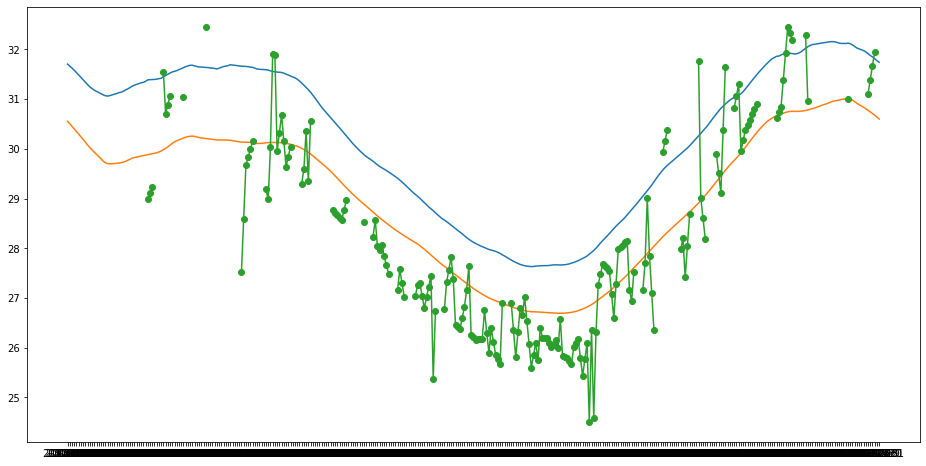

In [21]:
fig = plt.figure(figsize=(16,8))
plt.plot(nintyDF4.loc['20120101':'20121231'][17])
##plt.plot(nintyDF3.loc['20120101':'20121231'][17])
plt.plot(meanDF4.loc['20120101':'20121231'][17])
##plt.plot(meanDF3.loc['20120101':'20121231'][17])
plt.plot(testIDF1.loc['20120101':'20121231'][17],marker='o')

**The main function to identify the MHW events and generate statistics. Return three dataframes. 
One contains the summary statistics. Another contains the intensity of the MHW days, so that we can 
generate daily spatial statistics. The third contains the daily MHW classification. The function also saves individual MHW files and the summary statistics file.** 

In [22]:
import sys
import os
import numpy as np
from scipy.ndimage import label
import pandas as pd
from datetime import datetime

def do_analysis(sstDiff_data,threshold_data,lonlatDF,amp,outDir):
    
    print(datetime.now())
   
    
    # create a dataframe to store the MHW characteristics for each point
    mhwDF1 = pd.DataFrame()
    idList = [] # PointID
    noEvents = [] # total number of MHWs events, within the study period
    noDays = [] # total number of MHWs days, within the study period
    totalIntensity = [] # tota accumulated MHWs intensity (oC)
    overallIntensity = [] # overall mean MHWs intensity (oC)
    
    # the event with the highest intensity
    highestIntensity = [] # the maximum intensity of the event (oC)
    date_start_HI = [] # # the start date of the event (as the day number since 20150101)
    duration_HI = [] # the duration of the event
    
    # the event with the longest duration
    largestDuration = [] # the duration of the event 
    date_start_LD = [] # the start date of the event (as the day number since 20150101)
    intensityLD = [] # the mean intensity of the event
    
    # the event with the largest mean intensity
    largestMeanIntensity = [] # the mean intensity of event
    date_start_LMI = [] # the start day of the event (as the day number since 20150101)
    duration_LMI = [] # the duration of the event
    
    # the event with the largest cumulative intensity
    largestCumIntensity = [] # the cumulative intensity of the event
    date_start_LCI = [] # the start day of the event (as the day number since 20150101)
    duration_LCI = [] # the duration of the event
    
    # the MHW classification, based on Hobday et al. (2018)
    totalMoList = [] # total moderate MHW days
    totalStList = [] # total strong MHW days
    totalSeList = [] # total severe MHW days
    totalExList = [] # total extreme MHW days
    
    # daily MHW intensity
    statsDF = pd.DataFrame()
    statsDF['date'] = sstDiff_data.index
    statsDF.set_index('date',inplace=True)
    
    # daily MHW classification
    statsClassDF = pd.DataFrame()
    statsClassDF['date'] = sstDiff_data.index
    statsClassDF.set_index('date',inplace=True)
    


   
    # loop through each Point
    for id in sstDiff_data.columns:
        print(str(id))
        idList.append(id)
        # create a dataframe to store characteristics of the MHWs events identified for this point
        mhwE = pd.DataFrame()
        date_start = []
        date_end = []
        duration = []

        # get the point values as a numpy array, the empty value is NaN
        point1 = sstDiff_data[id]
        point1V = point1.values
        dates = sstDiff_data.index.values
        
        # get the threshold values as a numpy array, the empty value is NaN
        threshold1 = threshold_data[id]
        threshold1V = threshold1.values
        

        # replace the NaN values with '-9999'
        point1V_1 = np.where(np.isnan(point1V),-9999,point1V)
        # convert negative values into 0 and positive values into 1
        point1V_1[point1V_1<=0] = False
        point1V_1[point1V_1>0] = True
        # label events: positive value(s)
       
        events, n_events = label(point1V_1)
        #print(events)
        #print(n_events)
        for ev in range(1,n_events+1):
            # calculate duration of an event
            event_duration = (events == ev).sum()
            # initially identify all events with duration of 4+ days
            # isolated 4-day event(s) will be eventually removed
            if event_duration > 3:

                date_start.append(dates[np.where(events == ev)[0][0]])
                date_end.append(dates[np.where(events == ev)[0][-1]])
                duration.append(event_duration)
        # the initial list of mhwE
        mhwE['date_start'] = date_start
        mhwE['date_end'] = date_end
        mhwE['duration'] = duration

        # combine ajacent event(s) if they satisfy the criteria, this creates an updated list
        i = 0
        while i < mhwE.index.size - 1:

            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            gap = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            if gap < 3:
                # condition 1: [>=5 hot, 1 cool, 4 hot]; condition 2: [4 hot, 1 cool, >=5 hot]; condition 3: [>=5 hot, 1 cool, >=5 hot]
                if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] == 4) or  (mhwE.iloc[i]['duration'] == 4 and mhwE.iloc[i+1]['duration'] >=5) or  (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):
                    mhwE['date_end'][i] = mhwE['date_end'][i+1]
                    mhwE = mhwE.drop(i+1)
                    mhwE = mhwE.reset_index(drop=True)
                    i = i
                else:
                    i = i + 1
            elif gap < 4:
                # condition 4: [>=5 hot, 2 cool, >=5 hot]
                if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):              
                    mhwE['date_end'][i] = mhwE['date_end'][i+1]
                    mhwE = mhwE.drop(i+1)
                    mhwE = mhwE.reset_index(drop=True)
                    i = i
                else:
                    i = i + 1
            else:
                i = i + 1

        # drop the isolated event(s) with a duration of 4 days from the list
        i = 0
        while i < mhwE.index.size:
            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            if duration == 4:
                mhwE = mhwE.drop(i)
                mhwE = mhwE.reset_index(drop=True)
                i = i
            else:
                i = i + 1

        # update the durations of the final list
        i = 0
        while i < mhwE.index.size:
            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            mhwE['duration'][i] = duration
            i = i + 1

        # calculate mhw properties: intensity max, intensity mean, intensity std, 
        # cumulative intensity, onset rate and decline rate
        intensity_max = []
        intensity_mean = []
        intensity_std = []
        intensity_cumulative = []
        moderateD = []
        strongD = []
        severeD = []
        extremeD = []

        onset_rate = []
        decline_rate = []
        i = 0
        
        
        while i < mhwE.index.size:
            moderate = 0
            strong = 0
            severe = 0
            extreme = 0
            
            intensity_values = []
            date_values = []
            startDate = mhwE.iloc[i]['date_start']
            endDate = mhwE.iloc[i]['date_end']
            duration = mhwE.iloc[i]['duration']

            j = 0
            while j < sstDiff_data.index.size:

                date1 = dates[j]
                if startDate == date1:
                    k = j + int(duration)

                    while j < k:

                        sst_diff = point1V[j]
                        # calculate MHW classification
                        threshold = threshold1V[j]
                        ratio = sst_diff / threshold
                        if (ratio >= 0) & (ratio < 1.0):
                            moderate += 1
                        elif ratio < 2.0:
                            strong += 1
                        elif ratio < 3.0:
                            severe += 1
                        else:
                            extreme += 1
                            
                        intensity_values.append(sst_diff)
                        dateV = dates[j]
                        date_values.append(dateV)
                        j = j + 1
                else:
                    j = j + 1
            #print('event', i, ':', intensity_values)
            np_intensity = np.array(intensity_values)
            np_date = np.array(date_values)

            startDiff = np_intensity[0]
            endDiff = np_intensity[-1]
            maxDiff = np_intensity.max()
            meanDiff = np_intensity.mean()
            stdDiff = np_intensity.std()
            cumDiff = np_intensity.sum()
      
            peakDate = np_date[np_intensity == maxDiff][0]

            dateDiff1 = (datetime.strptime(str(peakDate),'%Y%m%d') - 
                        datetime.strptime(str(startDate),'%Y%m%d')).days
            if dateDiff1 > 0:        
                rateOnset = (maxDiff - startDiff) / dateDiff1
            else: # the start date is the peak date
                rateOnset = maxDiff / 0.5

            dateDiff2 = (datetime.strptime(str(endDate),'%Y%m%d') - 
                        datetime.strptime(str(peakDate),'%Y%m%d')).days
            if dateDiff2 > 0:        
                rateDecline = (maxDiff - endDiff) / dateDiff2
            else: # the end date is the peak date
                rateDecline = maxDiff / 0.5
            
            

            intensity_max.append(maxDiff)
            intensity_mean.append(meanDiff)
            intensity_std.append(stdDiff)
            intensity_cumulative.append(cumDiff)

            onset_rate.append(rateOnset)
            decline_rate.append(rateDecline)
            
            moderateD.append(moderate)
            strongD.append(strong)
            severeD.append(severe)
            extremeD.append(extreme)
            
            i = i + 1

        mhwE['maxIntensity'] = intensity_max
        mhwE['meanIntensity'] = intensity_mean
        mhwE['stdIntensity'] = intensity_std
        mhwE['cumIntensity'] = intensity_cumulative

        mhwE['onsetRate'] = onset_rate
        mhwE['declineRate'] = decline_rate
        
        mhwE['moderate'] = moderateD
        mhwE['strong'] = strongD
        mhwE['severe'] = severeD
        mhwE['extreme'] = extremeD

        # save the MHWs events identified for the point into a CSV file
        filename = os.path.join(outDir, 'mhw_' + str(id) + '.csv')
        mhwE.to_csv(filename, sep=',', index=False)
        
        
        # generate a statsDF to extract the intensity for the days identified as part of a MHW
        # generate a statsClassDF to extract the MHW classification for the days identified as part of a MHW
        if mhwE.index.size > 0:
            statsDF[str(id)] = np.nan
            statsClassDF[str(id)] = np.nan
            for j in mhwE.index:    
                date_start = str(int(mhwE.loc[j]['date_start']))
                date_end = str(int(mhwE.loc[j]['date_end']))
                x = sstDiff_data.loc[date_start:date_end][id].values
                y = thresholdDF4.loc[date_start:date_end][id].values
                # 2 -> moderate; 3 -> strong; 4 -> severe; 5 -> extreme
                z = np.array(x/y+2,dtype=int) # convert floating point to integer
                statsDF.loc[date_start:date_end,str(id)] = x
                statsClassDF.loc[date_start:date_end,str(id)] = z
                
         

    #   geneate the summary characteristics of the MHWs    
   
        if mhwE.index.size > 0:

            noEvents.append(mhwE.index.size)
            noDays.append(mhwE['duration'].sum())
            totalIntensity.append(mhwE['cumIntensity'].sum())
            overallIntensity.append(mhwE['cumIntensity'].sum()/mhwE['duration'].sum())
            
            totalMoList.append(mhwE['moderate'].sum())
            totalStList.append(mhwE['strong'].sum())
            totalSeList.append(mhwE['severe'].sum())
            totalExList.append(mhwE['extreme'].sum())

            tempDate = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['date_start']
            HIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599 # date number since 20150101
            HIDuration = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['duration']
            highestIntensity.append(mhwE['maxIntensity'].max())
            date_start_HI.append(HIDate)
            duration_HI.append(HIDuration)

            tempDate = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['date_start']
            LDDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            intensityLDV = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['meanIntensity']
            largestDuration.append(mhwE['duration'].max())
            date_start_LD.append(LDDate)
            intensityLD.append(intensityLDV)


            tempDate = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['date_start']
            LMIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            LMIDuration = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['duration']
            largestMeanIntensity.append(mhwE['meanIntensity'].max())
            date_start_LMI.append(LMIDate)
            duration_LMI.append(LMIDuration)    


            tempDate = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['date_start']
            LCIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            LCIDuration = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['duration']
            largestCumIntensity.append(mhwE['cumIntensity'].max())
            date_start_LCI.append(LCIDate)
            duration_LCI.append(LCIDuration)
        else:
            noEvents.append(0)
            noDays.append(0)
            totalIntensity.append(0)
            overallIntensity.append(0)
            
            totalMoList.append(0)
            totalStList.append(0)
            totalSeList.append(0)
            totalExList.append(0)

            highestIntensity.append(0)
            date_start_HI.append(0)
            duration_HI.append(0)


            largestDuration.append(0)
            date_start_LD.append(0)
            intensityLD.append(0)


            largestMeanIntensity.append(0)
            date_start_LMI.append(0)
            duration_LMI.append(0)

            largestCumIntensity.append(0)
            date_start_LCI.append(0)
            duration_LCI.append(0)            
        
        
    # populate the dataframe 
    mhwDF1['pointID'] = idList
    mhwDF1['lat'] = latlonDF.lat.values
    mhwDF1['lon'] = latlonDF.lon.values
    
    mhwDF1['noEvents'] = noEvents
    mhwDF1['noDays'] = noDays
    mhwDF1['totalIntensity'] = totalIntensity
    mhwDF1['overallIntensity'] = overallIntensity
    
    mhwDF1['highestIntensity'] = highestIntensity
    mhwDF1['date_start_HI'] = date_start_HI
    mhwDF1['duration_HI'] = duration_HI
    
    mhwDF1['largestDuration'] = largestDuration
    mhwDF1['date_start_LD'] = date_start_LD
    mhwDF1['intensityLD'] = intensityLD
    
    mhwDF1['largestMeanIntensity'] = largestMeanIntensity
    mhwDF1['date_start_LMI'] = date_start_LMI
    mhwDF1['duration_LMI'] = duration_LMI
    
    mhwDF1['largestCumIntensity'] = largestCumIntensity
    mhwDF1['date_start_LCI'] = date_start_LCI
    mhwDF1['duration_LCI'] = duration_LCI
    
    mhwDF1['moderate'] = totalMoList
    mhwDF1['strong'] = totalStList
    mhwDF1['severe'] = totalSeList
    mhwDF1['extreme'] = totalExList
          
    # save the summary characteristics to a CSV file
    mhwDF1.to_csv(os.path.join(outDir, 'results_' + amp + '.csv'), sep=',', index=False) 
    print(datetime.now())
    return mhwDF1, statsDF, statsClassDF


**Apply the main function**

In [23]:
outdir = '/home/547/zxh547/dea-notebooks/CI'
amp = 'CI'
mhwDF4, statsDF4, statsClassDF4 = do_analysis(diffDF4,thresholdDF4,latlonDF,amp,outdir)

2019-12-02 08:53:35.321709
17


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


18
19
20
27
28
29
30
31
32
33
34
38
39
40
41
42
43
44
45
46
47
50
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
98
99
100
101
102
103
104
105
106
107
110
111
112
113
114
115
116
117
118
119
123
124
125
126
127
128
129
130
136
137
138
139
140
141
2019-12-02 08:53:51.503933


In [24]:
mhwDF4.shape

(102, 23)

In [31]:
mhwDF4.tail(10)

,pointID,lat,lon,noEvents,noDays,totalIntensity,overallIntensity,highestIntensity,date_start_HI,duration_HI,...,largestMeanIntensity,date_start_LMI,duration_LMI,largestCumIntensity,date_start_LCI,duration_LCI,moderate,strong,severe,extreme
92,127,-1357850.0,-932750.0,8,60,42.097484,0.701625,2.383267,540,16,...,1.095251,540,16,17.524017,540,16,48,10,2,0
93,128,-1357850.0,-931450.0,11,90,54.318762,0.603542,2.407111,540,17,...,1.169179,540,17,19.876036,540,17,76,12,2,0
94,129,-1357850.0,-930150.0,8,74,50.948271,0.688490,2.597734,540,17,...,1.091379,540,17,18.553445,540,17,59,14,1,0
95,130,-1357850.0,-928850.0,9,75,49.894118,0.665255,2.639081,541,16,...,1.049999,-692,5,15.356193,541,16,59,15,1,0
96,136,-1359150.0,-936650.0,10,81,49.744058,0.614124,2.388162,533,13,...,0.983395,517,10,9.833952,517,10,67,13,1,0
97,137,-1359150.0,-935350.0,9,80,52.206073,0.652576,2.322961,539,18,...,1.119078,539,18,20.143407,539,18,67,11,2,0
98,138,-1359150.0,-934050.0,12,94,58.525000,0.622606,2.439981,-1985,6,...,0.998302,1195,5,13.897694,540,16,79,13,2,0
99,139,-1359150.0,-932750.0,10,83,50.071752,0.603274,2.241817,541,15,...,0.905792,541,15,13.586879,541,15,71,10,2,0
100,140,-1359150.0,-931450.0,8,64,37.034685,0.578667,1.654121,546,11,...,0.985487,546,11,12.536686,509,18,50,14,0,0
101,141,-1359150.0,-930150.0,10,65,38.152541,0.586962,1.807662,546,11,...,1.006971,520,7,11.069879,546,11,52,13,0,0


In [25]:
statsDF4.shape

(6210, 100)

In [33]:
statsDF4.head(10)

,17,18,19,20,27,28,29,30,31,32,...,127,128,129,130,136,137,138,139,140,141
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
statsClassDF4.shape

(6210, 100)

In [35]:
statsClassDF4.head(10)

,17,18,19,20,27,28,29,30,31,32,...,127,128,129,130,136,137,138,139,140,141
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
x = statsDF4.loc['20061202']
print(x)
print(np.count_nonzero(~np.isnan(x)))
x = testIDF1.loc['20061202']
# counting the number of not nan in x
print(np.count_nonzero(~np.isnan(x)))

17    NaN
18    NaN
19    NaN
20    NaN
27    NaN
       ..
137   NaN
138   NaN
139   NaN
140   NaN
141   NaN
Name: 20061202, Length: 100, dtype: float64
0
26


**Calculate summary statistics for the statsDF dataframe**

In [27]:
minList = []
maxList = []
meanList = []
stdList = []
countList = []
observedList = []
for i in statsDF4.index:
    minList.append(statsDF4.loc[i].min())
    maxList.append(statsDF4.loc[i].max())
    meanList.append(statsDF4.loc[i].mean())
    stdList.append(statsDF4.loc[i].std())
    countList.append(statsDF4.loc[i].count())
    x = testIDF1.loc[i]
    observed = np.count_nonzero(~np.isnan(x))
    observedList.append(observed)
statsDF4['min'] = minList
statsDF4['max'] = maxList
statsDF4['mean'] = meanList
statsDF4['std'] = stdList
statsDF4['count'] = countList
statsDF4['observed'] = observedList

    

In [28]:
statsDF4.tail(50)

,17,18,19,20,27,28,29,30,31,32,...,138,139,140,141,min,max,mean,std,count,observed
date,,,,,,,,,,,,,,,,,,,,,
20190603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,8
20190604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5
20190605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,73
20190606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,73
20190607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,96
20190608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,103
20190609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,103
20190610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,103
20190611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,103


**calculate the summary statistics for the statsClassDF**

In [29]:
moCountList = []
stCountList = []
seCountList = []
exCountList = []
countList = []
observedList = []
# the number of pixels of individual MHW classes
for i in statsClassDF4.index:
    x = statsClassDF4.loc[i]
    moCount = x[x==2].size
    stCount = x[x==3].size
    seCount = x[x==4].size
    exCount = x[x==5].size
    moCountList.append(moCount)
    stCountList.append(stCount)
    seCountList.append(seCount)
    exCountList.append(exCount)
    countList.append(x.count())
    y = testIDF1.loc[i]
    observed = np.count_nonzero(~np.isnan(y))
    observedList.append(observed)
statsClassDF4['moCount'] = moCountList
statsClassDF4['stCount'] = stCountList
statsClassDF4['seCount'] = seCountList
statsClassDF4['exCount'] = exCountList
statsClassDF4['count'] = countList
statsClassDF4['observed'] = observedList

    

In [30]:
statsClassDF4.head(50)

,17,18,19,20,27,28,29,30,31,32,...,138,139,140,141,moCount,stCount,seCount,exCount,count,observed
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,101
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,98
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,98
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,97
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,97
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,97
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,100
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,100
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,0,0,0,102


In [69]:
statsDF4.loc['20160601':'20160831']

,17,18,19,20,27,28,29,30,31,32,...,138,139,140,141,min,max,mean,std,count,observed
date,,,,,,,,,,,,,,,,,,,,,
20160601,0.464633,0.383790,0.588199,0.701268,0.379009,0.420750,0.450406,0.607035,0.709048,0.646674,...,0.485097,0.588016,0.625954,0.614989,0.161871,1.668823,0.652204,0.249834,93,101
20160602,0.670408,0.501436,0.520824,0.801479,0.478652,0.525040,0.537407,0.574174,0.771290,0.842755,...,0.577193,0.276469,0.277665,0.265313,0.002774,1.107003,0.581478,0.237450,70,89
20160603,0.876594,0.618307,0.454436,0.900551,0.573889,0.624307,0.625535,0.539046,0.832710,1.038063,...,0.664613,0.299758,0.329825,NaN,0.029452,1.200445,0.708955,0.251439,81,89
20160604,1.160247,1.131371,0.861275,1.091625,0.943330,1.115421,1.010229,0.781304,NaN,1.255192,...,0.968644,0.745693,0.841036,0.563191,0.185489,1.531492,0.994278,0.254716,84,85
20160605,1.446070,1.646331,1.268919,1.285769,1.320170,1.608565,1.397204,1.027976,NaN,1.474045,...,1.273225,1.192660,1.352890,1.208529,0.149055,2.036443,1.312653,0.361503,94,96
20160606,1.369356,1.541991,1.292193,1.409284,1.453701,1.618194,1.329333,1.308154,NaN,1.462772,...,1.229573,1.330829,1.463034,1.284263,0.552410,1.657453,1.301468,0.252619,94,96
20160607,1.292171,1.439193,1.315130,1.532922,1.589734,1.631968,1.258655,1.589147,NaN,1.451255,...,1.184243,1.470773,1.575034,1.360521,0.685276,1.824339,1.292359,0.223226,94,103
20160608,1.095170,1.094662,1.206000,1.290972,0.985185,0.923517,0.954028,0.872881,NaN,0.930804,...,0.748919,1.173595,1.037342,1.095426,0.662838,1.582529,1.102606,0.195070,94,103
20160609,0.849180,0.835903,0.843968,0.407390,0.330588,0.691847,0.720914,0.629124,NaN,NaN,...,0.762645,0.877161,0.983534,0.997344,0.177106,1.168403,0.799151,0.218858,91,102


In [46]:
numPoints = statsDF4.columns.size - 6
col1 = statsDF4.columns[0]
col2 = statsDF4.columns[numPoints-1]
print(col1,col2)
x=statsDF4.loc['20160601':'20160831',col1:col2].values
y=statsDF4.loc['20160601':'20160831','count'].values
print(x[x>=0].size)
z = statsDF4.loc['20160601':'20160831','observed'].values
k = z[y>0]
print(y.sum())
print(k.sum())

17 141
3338
3338
6255


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys


**Generate seasonal statistics for from statsDF**

In [31]:
seasonList = ['2002 winter','2002 spring','2002-03 summer','2003 autumn',
              '2003 winter','2003 spring','2003-04 summer','2004 autumn',
             '2004 winter','2004 spring','2004-05 summer','2005 autumn',
             '2005 winter','2005 spring','2005-06 summer','2006 autumn',
             '2006 winter','2006 spring','2006-07 summer','2007 autumn',
             '2007 winter','2007 spring','2007-08 summer','2008 autumn',
             '2008 winter','2008 spring','2008-09 summer','2009 autumn',
             '2009 winter','2009 spring','2009-10 summer','2010 autumn',
             '2010 winter','2010 spring','2010-11 summer','2011 autumn',
             '2011 winter','2011 spring','2011-12 summer','2012 autumn',
             '2012 winter','2012 spring','2012-13 summer','2013 autumn',
             '2013 winter','2013 spring','2013-14 summer','2014 autumn',
             '2014 winter','2014 spring','2014-15 summer','2015 autumn',
             '2015 winter','2015 spring','2015-16 summer','2016 autumn',
             '2016 winter','2016 spring','2016-17 summer','2017 autumn',
             '2017 winter','2017 spring','2017-18 summer','2018 autumn',
             '2018 winter','2018 spring','2018-19 summer','2019 autumn',
             '2019 winter']
seasonDF4 = pd.DataFrame()
seasonDF4['season'] = seasonList
seasonDF4.set_index('season',inplace=True)
minList = []
maxList = []
meanList = []
stdList = []
sumList = []
countList = []
observed1List = []
observed2List = []
mhwDaysList = []
noDaysList = []
numPoints = statsDF4.columns.size - 6
col1 = statsDF4.columns[0]
col2 = statsDF4.columns[numPoints-1]
print(col1,col2)
x=statsDF4.loc['20020704':'20020831',col1:col2].values

if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20020704':'20020831','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20020704':'20020831','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)

yearList = ['2002','2003','2004','2005','2006','2007','2008','2009',
            '2010','2011','2012','2013','2014','2015','2016','2017','2018']
i = 0
for year in yearList:
    if year == '2018':
        break
    date1 = year+'0901'
    date2 = year+'1130'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(z.size)
    
    date1 = year+'1201'
    date2 = yearList[i+1] + '0228'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(z.size)
    
    date1 = yearList[i+1] + '0301'
    date2 = yearList[i+1] + '0531'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(z.size)
    
    date1 = yearList[i+1] + '0601'
    date2 = yearList[i+1] + '0831' 
    print(date1,date2)
    x=statsDF4.loc[date1:date2,col1:col2].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    y=statsDF4.loc[date1:date2,'observed'].values
    observed2 = y.sum()
    observed2List.append(observed2)
    z=statsDF4.loc[date1:date2,'count'].values
    k = y[z>0]
    observed1List.append(k.sum())
    mhwDaysList.append(k.size)
    noDaysList.append(z.size)
    
    i += 1

x=statsDF4.loc['20180901':'20181130',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20180901':'20181130','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20180901':'20181130','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)

x=statsDF4.loc['20181201':'20190228',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20181201':'20190228','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20181201':'20190228','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)

x=statsDF4.loc['20190301':'20190531',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20190301':'20190531','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20190301':'20190531','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)

x=statsDF4.loc['20190601':'20190722',col1:col2].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)
y=statsDF4.loc['20190601':'20190722','observed'].values
observed2 = y.sum()
observed2List.append(observed2)
z=statsDF4.loc['20190601':'20190722','count'].values
k = y[z>0]
observed1List.append(k.sum())
mhwDaysList.append(k.size)
noDaysList.append(z.size)
print(noDaysList)

seasonDF4['min'] = minList
seasonDF4['max'] = maxList
seasonDF4['mean'] = meanList
seasonDF4['std'] = stdList
seasonDF4['sum'] = sumList
seasonDF4['count'] = countList
seasonDF4['observed1'] = observed1List
seasonDF4['observed2'] = observed2List
seasonDF4['mhwDays'] = mhwDaysList
seasonDF4['noDays'] = noDaysList


17 141
20020901 20021130
20021201 20030228
20030301 20030531
20030601 20030831
20030901 20031130
20031201 20040228
20040301 20040531
20040601 20040831
20040901 20041130
20041201 20050228
20050301 20050531
20050601 20050831
20050901 20051130
20051201 20060228
20060301 20060531
20060601 20060831
20060901 20061130
20061201 20070228
20070301 20070531
20070601 20070831
20070901 20071130
20071201 20080228
20080301 20080531
20080601 20080831
20080901 20081130
20081201 20090228
20090301 20090531
20090601 20090831
20090901 20091130
20091201 20100228
20100301 20100531
20100601 20100831
20100901 20101130
20101201 20110228
20110301 20110531
20110601 20110831
20110901 20111130
20111201 20120228
20120301 20120531
20120601 20120831
20120901 20121130
20121201 20130228
20130301 20130531
20130601 20130831
20130901 20131130
20131201 20140228
20140301 20140531
20140601 20140831
20140901 20141130
20141201 20150228
20150301 20150531
20150601 20150831
20150901 20151130
20151201 20160228
20160301 20160531
201

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3

20180301 20180531
20180601 20180831
[51, 91, 90, 92, 92, 91, 90, 92, 92, 91, 89, 92, 92, 91, 90, 92, 91, 91, 90, 92, 91, 91, 89, 92, 92, 91, 90, 92, 91, 91, 90, 92, 92, 91, 90, 92, 92, 91, 90, 92, 92, 91, 90, 92, 92, 91, 90, 92, 92, 91, 90, 92, 92, 91, 90, 92, 91, 91, 90, 92, 92, 91, 90, 92, 92, 91, 90, 92, 52]


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:178: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:202: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:226: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:250: RuntimeWarning: invalid value encountered in greater_equal


In [40]:
mo=statsClassDF4.loc['20181201':'20190228','moCount'].values
st=statsClassDF4.loc['20181201':'20190228','stCount'].values
se=statsClassDF4.loc['20181201':'20190228','seCount'].values
ex=statsClassDF4.loc['20181201':'20190228','exCount'].values
print(mo.sum(),st.sum(),se.sum(),ex.sum())

x=statsClassDF4.loc['20181201':'20190228','moCount':'exCount'].values
i = 0
exDays = 0
seDays = 0
stDays = 0
moDays = 0

while i < x[:,1].size:
    
    if x[i,3] > 0:
        exDays += 1
    elif x[i,2] > 0:
        seDays += 1
    elif x[i,1] > 0:
        stDays += 1
    elif x[i,0] > 0:
        moDays += 1 
    
    i += 1
print(moDays,stDays,seDays,exDays)

0 0 0 0
0 0 0 0


**generate seasonal statistics from statsClassDF**

In [32]:
seasonList = ['2002 winter','2002 spring','2002-03 summer','2003 autumn',
              '2003 winter','2003 spring','2003-04 summer','2004 autumn',
             '2004 winter','2004 spring','2004-05 summer','2005 autumn',
             '2005 winter','2005 spring','2005-06 summer','2006 autumn',
             '2006 winter','2006 spring','2006-07 summer','2007 autumn',
             '2007 winter','2007 spring','2007-08 summer','2008 autumn',
             '2008 winter','2008 spring','2008-09 summer','2009 autumn',
             '2009 winter','2009 spring','2009-10 summer','2010 autumn',
             '2010 winter','2010 spring','2010-11 summer','2011 autumn',
             '2011 winter','2011 spring','2011-12 summer','2012 autumn',
             '2012 winter','2012 spring','2012-13 summer','2013 autumn',
             '2013 winter','2013 spring','2013-14 summer','2014 autumn',
             '2014 winter','2014 spring','2014-15 summer','2015 autumn',
             '2015 winter','2015 spring','2015-16 summer','2016 autumn',
             '2016 winter','2016 spring','2016-17 summer','2017 autumn',
             '2017 winter','2017 spring','2017-18 summer','2018 autumn',
             '2018 winter','2018 spring','2018-19 summer','2019 autumn',
             '2019 winter']
seasonClassDF4 = pd.DataFrame()
seasonClassDF4['season'] = seasonList
seasonClassDF4.set_index('season',inplace=True)
moCountList = []
stCountList = []
seCountList = []
exCountList = []
moDaysList = []
stDaysList = []
seDaysList = []
exDaysList = []

mo=statsClassDF4.loc['20020704':'20020831','moCount'].values
st=statsClassDF4.loc['20020704':'20020831','stCount'].values
se=statsClassDF4.loc['20020704':'20020831','seCount'].values
ex=statsClassDF4.loc['20020704':'20020831','exCount'].values
moCountList.append(mo.sum())
stCountList.append(st.sum())
seCountList.append(se.sum())
exCountList.append(ex.sum())

x=statsClassDF4.loc['20020704':'20020831','moCount':'exCount'].values
i = 0
exDays = 0
seDays = 0
stDays = 0
moDays = 0
while i < x[:,1].size:    
    if x[i,3] > 0:
        exDays += 1
    elif x[i,2] > 0:
        seDays += 1
    elif x[i,1] > 0:
        stDays += 1
    elif x[i,0] > 0:
        moDays += 1     
    i += 1
moDaysList.append(moDays)
stDaysList.append(stDays)
seDaysList.append(seDays)
exDaysList.append(exDays)


yearList = ['2002','2003','2004','2005','2006','2007','2008','2009',
            '2010','2011','2012','2013','2014','2015','2016','2017','2018']
j = 0
for year in yearList:
    if year == '2018':
        break
    date1 = year+'0901'
    date2 = year+'1130'
    print(date1,date2)    
    mo=statsClassDF4.loc[date1:date2,'moCount'].values
    st=statsClassDF4.loc[date1:date2,'stCount'].values
    se=statsClassDF4.loc[date1:date2,'seCount'].values
    ex=statsClassDF4.loc[date1:date2,'exCount'].values
    moCountList.append(mo.sum())
    stCountList.append(st.sum())
    seCountList.append(se.sum())
    exCountList.append(ex.sum())

    x=statsClassDF4.loc[date1:date2,'moCount':'exCount'].values
    i = 0
    exDays = 0
    seDays = 0
    stDays = 0
    moDays = 0
    while i < x[:,1].size:    
        if x[i,3] > 0:
            exDays += 1
        elif x[i,2] > 0:
            seDays += 1
        elif x[i,1] > 0:
            stDays += 1
        elif x[i,0] > 0:
            moDays += 1     
        i += 1
    moDaysList.append(moDays)
    stDaysList.append(stDays)
    seDaysList.append(seDays)
    exDaysList.append(exDays)
    
    date1 = year+'1201'
    date2 = yearList[j+1] + '0228'
    print(date1,date2)
    mo=statsClassDF4.loc[date1:date2,'moCount'].values
    st=statsClassDF4.loc[date1:date2,'stCount'].values
    se=statsClassDF4.loc[date1:date2,'seCount'].values
    ex=statsClassDF4.loc[date1:date2,'exCount'].values
    moCountList.append(mo.sum())
    stCountList.append(st.sum())
    seCountList.append(se.sum())
    exCountList.append(ex.sum())

    x=statsClassDF4.loc[date1:date2,'moCount':'exCount'].values
    i = 0
    exDays = 0
    seDays = 0
    stDays = 0
    moDays = 0
    while i < x[:,1].size:    
        if x[i,3] > 0:
            exDays += 1
        elif x[i,2] > 0:
            seDays += 1
        elif x[i,1] > 0:
            stDays += 1
        elif x[i,0] > 0:
            moDays += 1     
        i += 1
    moDaysList.append(moDays)
    stDaysList.append(stDays)
    seDaysList.append(seDays)
    exDaysList.append(exDays)
    
    date1 = yearList[j+1] + '0301'
    date2 = yearList[j+1] + '0531'
    print(date1,date2)
    mo=statsClassDF4.loc[date1:date2,'moCount'].values
    st=statsClassDF4.loc[date1:date2,'stCount'].values
    se=statsClassDF4.loc[date1:date2,'seCount'].values
    ex=statsClassDF4.loc[date1:date2,'exCount'].values
    moCountList.append(mo.sum())
    stCountList.append(st.sum())
    seCountList.append(se.sum())
    exCountList.append(ex.sum())

    x=statsClassDF4.loc[date1:date2,'moCount':'exCount'].values
    i = 0
    exDays = 0
    seDays = 0
    stDays = 0
    moDays = 0
    while i < x[:,1].size:    
        if x[i,3] > 0:
            exDays += 1
        elif x[i,2] > 0:
            seDays += 1
        elif x[i,1] > 0:
            stDays += 1
        elif x[i,0] > 0:
            moDays += 1     
        i += 1
    moDaysList.append(moDays)
    stDaysList.append(stDays)
    seDaysList.append(seDays)
    exDaysList.append(exDays)
    
    date1 = yearList[j+1] + '0601'
    date2 = yearList[j+1] + '0831' 
    print(date1,date2)
    mo=statsClassDF4.loc[date1:date2,'moCount'].values
    st=statsClassDF4.loc[date1:date2,'stCount'].values
    se=statsClassDF4.loc[date1:date2,'seCount'].values
    ex=statsClassDF4.loc[date1:date2,'exCount'].values
    moCountList.append(mo.sum())
    stCountList.append(st.sum())
    seCountList.append(se.sum())
    exCountList.append(ex.sum())

    x=statsClassDF4.loc[date1:date2,'moCount':'exCount'].values
    i = 0
    exDays = 0
    seDays = 0
    stDays = 0
    moDays = 0
    while i < x[:,1].size:    
        if x[i,3] > 0:
            exDays += 1
        elif x[i,2] > 0:
            seDays += 1
        elif x[i,1] > 0:
            stDays += 1
        elif x[i,0] > 0:
            moDays += 1     
        i += 1
    moDaysList.append(moDays)
    stDaysList.append(stDays)
    seDaysList.append(seDays)
    exDaysList.append(exDays)
    
    j += 1

mo=statsClassDF4.loc['20180901':'20181130','moCount'].values
st=statsClassDF4.loc['20180901':'20181130','stCount'].values
se=statsClassDF4.loc['20180901':'20181130','seCount'].values
ex=statsClassDF4.loc['20180901':'20181130','exCount'].values
moCountList.append(mo.sum())
stCountList.append(st.sum())
seCountList.append(se.sum())
exCountList.append(ex.sum())

x=statsClassDF4.loc['20180901':'20181130','moCount':'exCount'].values
i = 0
exDays = 0
seDays = 0
stDays = 0
moDays = 0
while i < x[:,1].size:    
    if x[i,3] > 0:
        exDays += 1
    elif x[i,2] > 0:
        seDays += 1
    elif x[i,1] > 0:
        stDays += 1
    elif x[i,0] > 0:
        moDays += 1     
    i += 1
moDaysList.append(moDays)
stDaysList.append(stDays)
seDaysList.append(seDays)
exDaysList.append(exDays)

mo=statsClassDF4.loc['20181201':'20190228','moCount'].values
st=statsClassDF4.loc['20181201':'20190228','stCount'].values
se=statsClassDF4.loc['20181201':'20190228','seCount'].values
ex=statsClassDF4.loc['20181201':'20190228','exCount'].values
moCountList.append(mo.sum())
stCountList.append(st.sum())
seCountList.append(se.sum())
exCountList.append(ex.sum())

x=statsClassDF4.loc['20181201':'20190228','moCount':'exCount'].values
i = 0
exDays = 0
seDays = 0
stDays = 0
moDays = 0
while i < x[:,1].size:    
    if x[i,3] > 0:
        exDays += 1
    elif x[i,2] > 0:
        seDays += 1
    elif x[i,1] > 0:
        stDays += 1
    elif x[i,0] > 0:
        moDays += 1     
    i += 1
moDaysList.append(moDays)
stDaysList.append(stDays)
seDaysList.append(seDays)
exDaysList.append(exDays)

mo=statsClassDF4.loc['20190301':'20190531','moCount'].values
st=statsClassDF4.loc['20190301':'20190531','stCount'].values
se=statsClassDF4.loc['20190301':'20190531','seCount'].values
ex=statsClassDF4.loc['20190301':'20190531','exCount'].values
moCountList.append(mo.sum())
stCountList.append(st.sum())
seCountList.append(se.sum())
exCountList.append(ex.sum())

x=statsClassDF4.loc['20190301':'20190531','moCount':'exCount'].values
i = 0
exDays = 0
seDays = 0
stDays = 0
moDays = 0
while i < x[:,1].size:    
    if x[i,3] > 0:
        exDays += 1
    elif x[i,2] > 0:
        seDays += 1
    elif x[i,1] > 0:
        stDays += 1
    elif x[i,0] > 0:
        moDays += 1     
    i += 1
moDaysList.append(moDays)
stDaysList.append(stDays)
seDaysList.append(seDays)
exDaysList.append(exDays)

mo=statsClassDF4.loc['20190601':'20190722','moCount'].values
st=statsClassDF4.loc['20190601':'20190722','stCount'].values
se=statsClassDF4.loc['20190601':'20190722','seCount'].values
ex=statsClassDF4.loc['20190601':'20190722','exCount'].values
moCountList.append(mo.sum())
stCountList.append(st.sum())
seCountList.append(se.sum())
exCountList.append(ex.sum())

x=statsClassDF4.loc['20190601':'20190722','moCount':'exCount'].values
i = 0
exDays = 0
seDays = 0
stDays = 0
moDays = 0
while i < x[:,1].size:    
    if x[i,3] > 0:
        exDays += 1
    elif x[i,2] > 0:
        seDays += 1
    elif x[i,1] > 0:
        stDays += 1
    elif x[i,0] > 0:
        moDays += 1     
    i += 1
moDaysList.append(moDays)
stDaysList.append(stDays)
seDaysList.append(seDays)
exDaysList.append(exDays)

seasonClassDF4['moCount'] = moCountList
seasonClassDF4['stCount'] = stCountList
seasonClassDF4['seCount'] = seCountList
seasonClassDF4['exCount'] = exCountList
seasonClassDF4['moDays'] = moDaysList
seasonClassDF4['stDays'] = stDaysList
seasonClassDF4['seDays'] = seDaysList
seasonClassDF4['exDays'] = exDaysList
seasonClassDF4['count'] = seasonDF4['count']
seasonClassDF4['observed1'] = seasonDF4['observed1']
seasonClassDF4['observed2'] = seasonDF4['observed2']
seasonClassDF4['mhwDays'] = seasonDF4['mhwDays']
seasonClassDF4['noDays'] = seasonDF4['noDays']


20020901 20021130
20021201 20030228
20030301 20030531
20030601 20030831
20030901 20031130
20031201 20040228
20040301 20040531
20040601 20040831
20040901 20041130
20041201 20050228
20050301 20050531
20050601 20050831
20050901 20051130
20051201 20060228
20060301 20060531
20060601 20060831
20060901 20061130
20061201 20070228
20070301 20070531
20070601 20070831
20070901 20071130
20071201 20080228
20080301 20080531
20080601 20080831
20080901 20081130
20081201 20090228
20090301 20090531
20090601 20090831
20090901 20091130
20091201 20100228
20100301 20100531
20100601 20100831
20100901 20101130
20101201 20110228
20110301 20110531
20110601 20110831
20110901 20111130
20111201 20120228
20120301 20120531
20120601 20120831
20120901 20121130
20121201 20130228
20130301 20130531
20130601 20130831
20130901 20131130
20131201 20140228
20140301 20140531
20140601 20140831
20140901 20141130
20141201 20150228
20150301 20150531
20150601 20150831
20150901 20151130
20151201 20160228
20160301 20160531
20160601 2

In [33]:
seasonDF4.tail(40)

,min,max,mean,std,sum,count,observed1,observed2,mhwDays,noDays
season,,,,,,,,,,
2009 spring,0.013037,1.637861,0.507967,0.323258,193.027321,380,972,4036,13,91
2009-10 summer,NaN,NaN,NaN,NaN,NaN,0,0,1413,0,90
2010 autumn,0.061556,0.862878,0.359173,0.299794,1.795864,5,488,4238,5,92
2010 winter,0.003483,2.238939,0.574843,0.638741,18.394968,32,662,6043,7,92
2010 spring,NaN,NaN,NaN,NaN,NaN,0,0,3701,0,91
2010-11 summer,NaN,NaN,NaN,NaN,NaN,0,0,708,0,90
2011 autumn,NaN,NaN,NaN,NaN,NaN,0,0,2481,0,92
2011 winter,NaN,NaN,NaN,NaN,NaN,0,0,7554,0,92
2011 spring,NaN,NaN,NaN,NaN,NaN,0,0,4018,0,91


In [34]:
seasonClassDF4.tail(40)

,moCount,stCount,seCount,exCount,moDays,stDays,seDays,exDays,count,observed1,observed2,mhwDays,noDays
season,,,,,,,,,,,,,
2009 spring,366,14,0,0,11,2,0,0,380,972,4036,13,91
2009-10 summer,0,0,0,0,0,0,0,0,0,0,1413,0,90
2010 autumn,5,0,0,0,5,0,0,0,5,488,4238,5,92
2010 winter,26,5,1,0,6,0,1,0,32,662,6043,7,92
2010 spring,0,0,0,0,0,0,0,0,0,0,3701,0,91
2010-11 summer,0,0,0,0,0,0,0,0,0,0,708,0,90
2011 autumn,0,0,0,0,0,0,0,0,0,0,2481,0,92
2011 winter,0,0,0,0,0,0,0,0,0,0,7554,0,92
2011 spring,0,0,0,0,0,0,0,0,0,0,4018,0,91


**Plot a figure usign the seasonal statistics. The height of the y-axis shows the number of cells that have been 
identified as MHW days for each season. The colors indicates other statistics, for example the maximum MHW intensity 
in this case.**

[-10.   0.  10.  20.  30.  40.  50.  60.  70.  80.  90.]


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


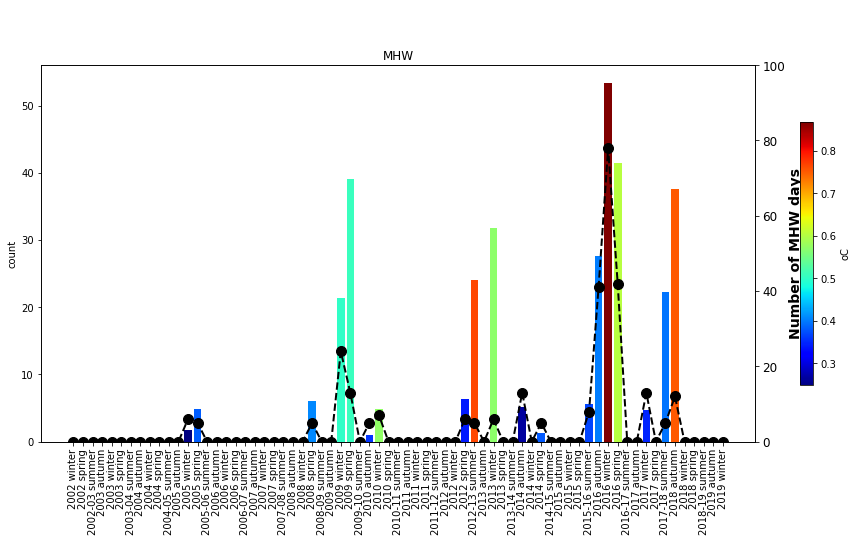

In [35]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(16,8))
cmap = matplotlib.cm.get_cmap('jet')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = seasonDF4.index.values
y = seasonDF4['count'].values / seasonDF4['observed1'] * 100
z1 = seasonDF4['mean'].values # display as colormap according to its values
mhwDays = seasonDF4['mhwDays'].values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row
# plot a line for the lower row
#ax1.plot(x, y, color='black', linestyle='-', marker='')
# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], y[i], facecolor=cmap(z2[i]), alpha=1)
    i += 1

ax2 = ax1.twinx()
ax2.plot(x, mhwDays, color='black', linestyle='dashed', marker='o', linewidth=2, markersize=10)
ax2.set_ylabel('Number of MHW days', fontsize=14, fontweight='bold')
ax2.tick_params(colors='black',labelsize=12)
loc = ax2.get_yticks()
print(loc)
ax2.set_ylim(0,100)

ax1.set_ylabel('count')
ax1.set_title('MHW')
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('oC')
plt.show()

In [49]:
import plotly.graph_objs as go

In [92]:
x = seasonDF4.index.values
y = seasonDF4['count'].values / seasonDF4['observed1'] * 100
f1 = go.FigureWidget(data=[go.Bar(x=x,y=y)])
bar1 = f1.data[0]
f1


def displayX(trace,points,state):
    selected = bar1.x[points.point_inds]
    print(selected)
    if selected == '2016 winter':
        
        winter2016 = statsDF4.loc['20160601':'20160831']
        x = winter2016.index.values
        y = winter2016['count'].values / winter2016['observed'] * 100
        print(y)

bar1.on_click(displayX)

FigureWidget({
    'data': [{'type': 'bar',
              'uid': 'd59f4f54-52c8-48f3-bc81-627df9e4e17f',
     …

['2016 winter']
date
20160601    92.079208
20160602    78.651685
20160603    91.011236
20160604    98.823529
20160605    97.916667
              ...    
20160827     0.000000
20160828     0.000000
20160829     0.000000
20160830     0.000000
20160831     0.000000
Name: observed, Length: 91, dtype: float64


**plot a figure showing the stacked bars of MHW classes (number of pixels) from the seasonClassDF**

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


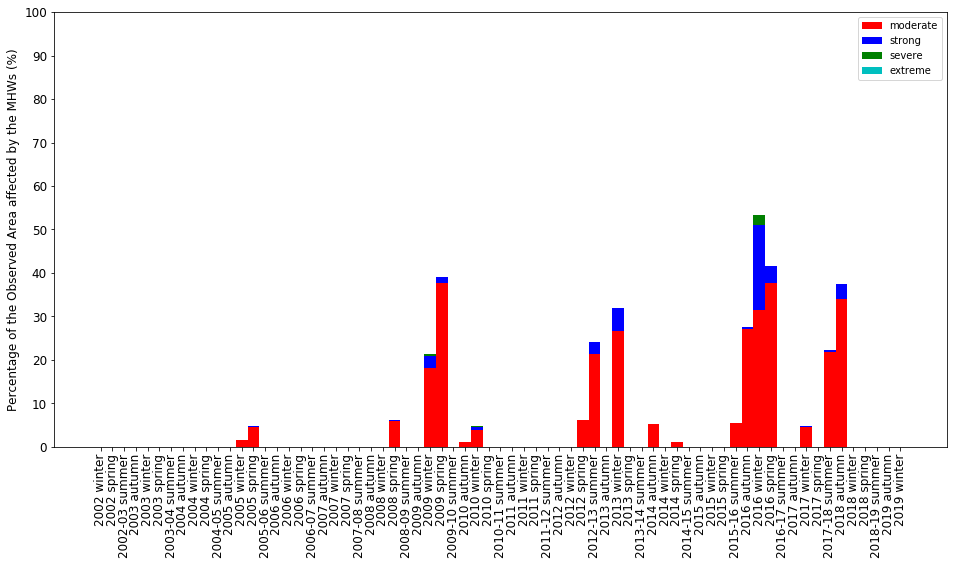

In [36]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(16,8))
# set up data
seasons = seasonClassDF4.index.values
moCount = seasonClassDF4['moCount'].values
stCount = seasonClassDF4['stCount'].values
seCount = seasonClassDF4['seCount'].values
exCount = seasonClassDF4['exCount'].values
count = seasonClassDF4['observed1'].values

moP = moCount / count * 100
moP = np.nan_to_num(moP)
stP = stCount / count * 100
stP = np.nan_to_num(stP)
seP = seCount / count * 100
seP = np.nan_to_num(seP)
exP = exCount / count * 100
exP = np.nan_to_num(exP)
width = 1.0
plt.ylim([0,100])
p1 = plt.bar(seasons,moP,width,color='r')
p2 = plt.bar(seasons,stP,width,bottom=moP,color='b')
p3 = plt.bar(seasons,seP,width,bottom=moP+stP,color='g')
p4 = plt.bar(seasons,exP,width,bottom=moP+stP+seP,color='c')
plt.yticks(np.arange(0,110,10))
plt.legend((p1[0],p2[0],p3[0],p4[0]),('moderate','strong','severe','extreme'))
plt.ylabel("Percentage of the Observed Area affected by the MHWs (%)",fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=90)
plt.show()


**plot a figure showing the stacked bars of MHW classes (number of days) from the seasonClassDF**

78


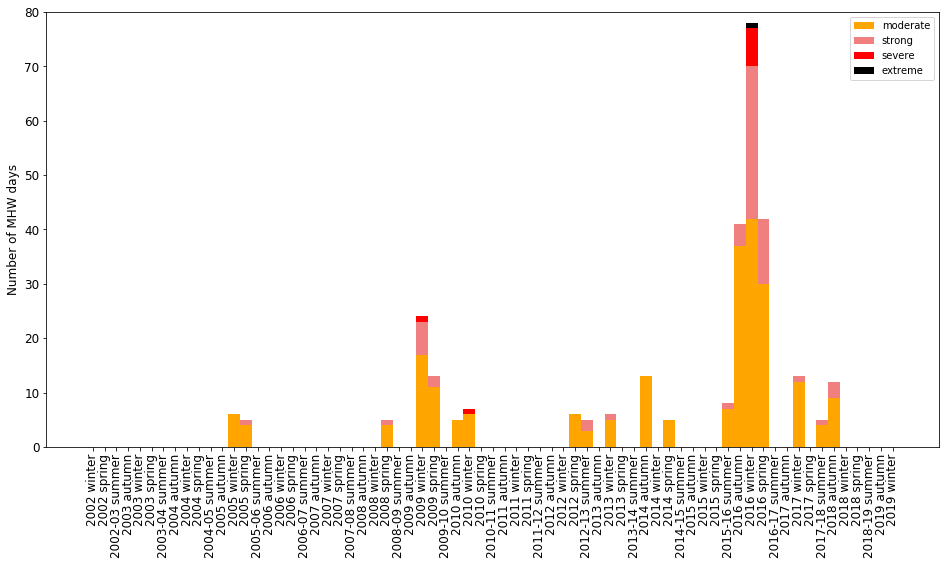

In [37]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(16,8))
# set up data
seasons = seasonClassDF4.index.values
moDays = seasonClassDF4['moDays'].values
stDays = seasonClassDF4['stDays'].values
seDays = seasonClassDF4['seDays'].values
exDays = seasonClassDF4['exDays'].values
max_mhwDays = seasonClassDF4['mhwDays'].values.max()
print(max_mhwDays)

width = 1.0
plt.ylim([0,max_mhwDays])
p1 = plt.bar(seasons,moDays,width,color='orange')
p2 = plt.bar(seasons,stDays,width,bottom=moDays,color='lightcoral')
p3 = plt.bar(seasons,seDays,width,bottom=moDays+stDays,color='red')
p4 = plt.bar(seasons,exDays,width,bottom=moDays+stDays+seDays,color='black')
plt.yticks(np.arange(0,max_mhwDays+10,10))
plt.legend((p1[0],p2[0],p3[0],p4[0]),('moderate','strong','severe','extreme'))
plt.ylabel("Number of MHW days",fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=90)
plt.show()


In [187]:
statsDF4.loc['20160601':'20160831','min':'observed']

,min,max,mean,std,count,observed
date,,,,,,
20160601,0.161871,1.668823,0.652204,0.249834,93,101
20160602,0.002774,1.107003,0.581478,0.237450,70,89
20160603,0.029452,1.200445,0.708955,0.251439,81,89
20160604,0.185489,1.531492,0.994278,0.254716,84,85
20160605,0.149055,2.036443,1.312653,0.361503,94,96
20160606,0.552410,1.657453,1.301468,0.252619,94,96
20160607,0.685276,1.824339,1.292359,0.223226,94,103
20160608,0.662838,1.582529,1.102606,0.195070,94,103
20160609,0.177106,1.168403,0.799151,0.218858,91,102


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


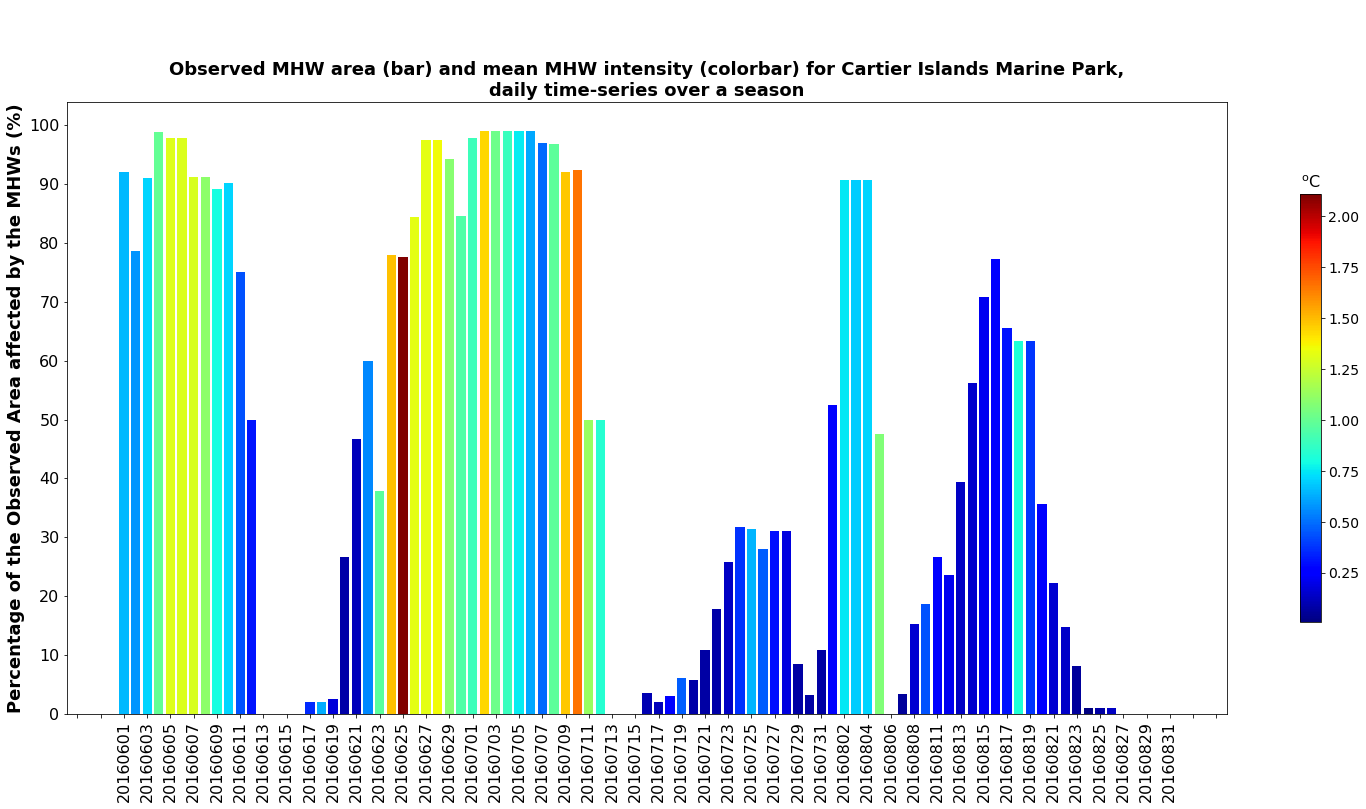

In [38]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as plticker

fig = plt.figure(figsize=(26,13))
cmap = matplotlib.cm.get_cmap('jet')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
winter2016 = statsDF4.loc['20160601':'20160831']
x = winter2016.index.values
y = winter2016['count'].values / winter2016['observed'] * 100
z1 = winter2016['mean'].values # display as colormap according to its values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row
# plot a line for the lower row
#ax1.plot(x, y, color='black', linestyle='-', marker='')
# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], y[i], facecolor=cmap(z2[i]), alpha=1)
    i += 1

ax1.set_ylabel('Percentage of the Observed Area affected by the MHWs (%)',fontsize=18,fontweight='bold')
ax1.set_title('Observed MHW area (bar) and mean MHW intensity (colorbar) for Cartier Islands Marine Park,' + '\n' + 'daily time-series over a season', fontsize=18, fontweight='bold')
ax1.set_yticks(np.arange(0,110,10))
ax1.set_yticklabels(np.arange(0,110,10),fontsize=16)
loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax1.xaxis.set_major_locator(loc)
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(16)
#ax1.tick_params(colors='black',labelsize=14)
#ax1.set_xticks(fontsize=12)
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.ax.set_title('$\mathregular{^oC}$', fontsize=16, rotation=0)
cbar.ax.tick_params(labelsize=14)
plt.show()

In [201]:
statsClassDF4.loc['20160601':'20160831','moCount':'observed']

,moCount,stCount,seCount,exCount,count,observed
date,,,,,,
20160601,87,6,0,0,93,101
20160602,69,1,0,0,70,89
20160603,74,7,0,0,81,89
20160604,41,43,0,0,84,85
20160605,18,74,2,0,94,96
20160606,13,81,0,0,94,96
20160607,10,84,0,0,94,103
20160608,30,64,0,0,94,103
20160609,71,20,0,0,91,102


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


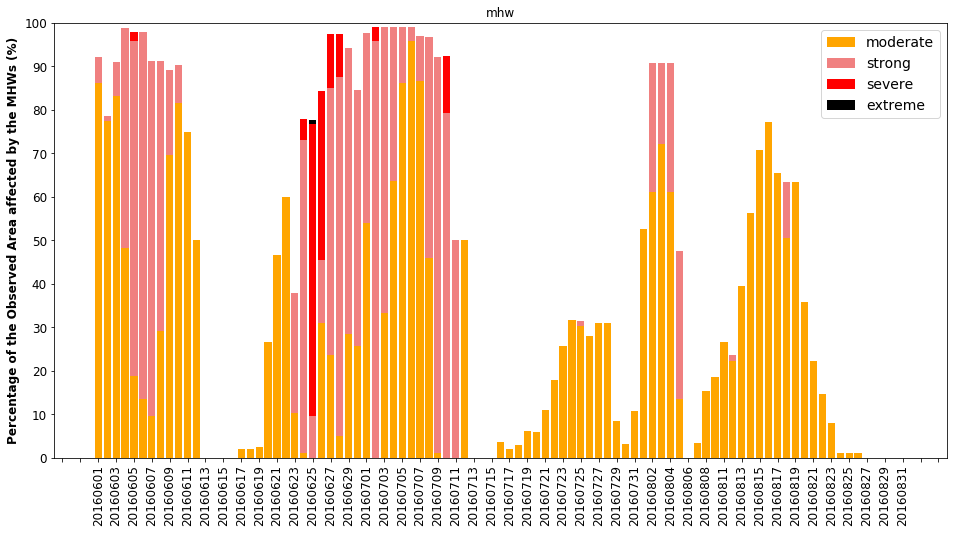

In [39]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as plticker

fig = plt.figure(figsize=(16,8))
# set up data
winter2016 = statsClassDF4.loc['20160601':'20160831']
days = winter2016.index.values
moCount = winter2016['moCount'].values
stCount = winter2016['stCount'].values
seCount = winter2016['seCount'].values
exCount = winter2016['exCount'].values
count = winter2016['observed'].values

moP = moCount / count * 100
moP = np.nan_to_num(moP)
stP = stCount / count * 100
stP = np.nan_to_num(stP)
seP = seCount / count * 100
seP = np.nan_to_num(seP)
exP = exCount / count * 100
exP = np.nan_to_num(exP)
width = 0.8
plt.ylim([0,100])
p1 = plt.bar(days,moP,width,color='orange')
p2 = plt.bar(days,stP,width,bottom=moP,color='lightcoral')
p3 = plt.bar(days,seP,width,bottom=moP+stP,color='red')
p4 = plt.bar(days,exP,width,bottom=moP+stP+seP,color='black')
plt.yticks(np.arange(0,110,10))
plt.legend((p1[0],p2[0],p3[0],p4[0]),('moderate','strong','severe','extreme'),fontsize=14)
plt.ylabel("Percentage of the Observed Area affected by the MHWs (%)",fontsize=12,fontweight='bold')
plt.title("mhw")
loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax = plt.axes()
ax.xaxis.set_major_locator(loc)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=90)
plt.show()

In [40]:
mhwDF4.set_index('pointID',inplace=True)

**add x and y coordinates (must be integer) to the dataframe**

In [41]:
statsDF5 = statsDF4.copy()
statsDF5 = statsDF5.drop(columns=['min','max','mean','std','count','observed'])
xList = []
yList = []
for i in statsDF5.columns:
    x = int(mhwDF4['lon'][int(i)])
    y = int(mhwDF4['lat'][int(i)])
    xList.append(x)
    yList.append(y)
statsDF5 = statsDF5.T
statsDF5['x']=xList
statsDF5['y']=yList
statsDF5.index.names = ['pointID']

**the same as above, but delete rows (dates) that have not impacted by the MHW. This signficantly reduces the size of 
the dataframe, which results in much smaller netcdf file being exported and aslo faster processing time**

In [42]:
statsDF6 = statsDF4.copy()
for i in statsDF6.index:
    count = statsDF6.loc[i,'count']
    if count == 0:
        statsDF6.drop(index=i,inplace=True)
statsDF6 = statsDF6.drop(columns=['min','max','mean','std','count','observed'])
xList = []
yList = []
for i in statsDF6.columns:
    x = int(mhwDF4['lon'][int(i)])
    y = int(mhwDF4['lat'][int(i)])
    xList.append(x)
    yList.append(y)
statsDF6 = statsDF6.T
statsDF6['x']=xList
statsDF6['y']=yList
statsDF6.index.names = ['pointID']

In [43]:
statsClassDF5 = statsClassDF4.copy()
statsClassDF5 = statsClassDF4.drop(columns=['moCount','stCount','seCount','exCount','count','observed'])
xList = []
yList = []
for i in statsClassDF5.columns:
    x = int(mhwDF4['lon'][int(i)])
    y = int(mhwDF4['lat'][int(i)])
    xList.append(x)
    yList.append(y)
statsClassDF5 = statsClassDF5.T
statsClassDF5['x']=xList
statsClassDF5['y']=yList
statsClassDF5.index.names = ['pointID']


In [44]:
statsClassDF6 = statsClassDF4.copy()
for i in statsClassDF6.index:
    count = statsClassDF6.loc[i,'count']
    if count == 0:
        statsClassDF6.drop(index=i,inplace=True)
statsClassDF6 = statsClassDF6.drop(columns=['moCount','stCount','seCount','exCount','count','observed'])
xList = []
yList = []
for i in statsClassDF6.columns:
    x = int(mhwDF4['lon'][int(i)])
    y = int(mhwDF4['lat'][int(i)])
    xList.append(x)
    yList.append(y)
statsClassDF6 = statsClassDF6.T
statsClassDF6['x']=xList
statsClassDF6['y']=yList
statsClassDF6.index.names = ['pointID']

In [47]:
statsClassDF6

date,20050616,20050617,20050618,20050619,20050620,20050621,20051009,20051010,20051011,20051012,...,20180413,20180414,20180415,20180416,20180417,20180418,20180419,20180420,x,y
pointID,,,,,,,,,,,,,,,,,,,,,
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,-935350,-1346150
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,-934050,-1346150
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-932750,-1346150
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,-931450,-1346150
27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-937950,-1347450
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-936650,-1347450
29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,-935350,-1347450
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,-934050,-1347450
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-932750,-1347450


**convert the summary statistics into xarray dataset, then export as netcdf file, so that we can display them 
as maps**

In [45]:
mhwDF5 = mhwDF4.copy()

In [46]:
x = np.array(mhwDF4.lon.values,dtype=np.int)
y = np.array(mhwDF4.lat.values,dtype=np.int)
mhwDF5['x'] = x
mhwDF5['y'] = y
mhwDF5.drop(columns=['lat','lon'])

,noEvents,noDays,totalIntensity,overallIntensity,highestIntensity,date_start_HI,duration_HI,largestDuration,date_start_LD,intensityLD,...,duration_LMI,largestCumIntensity,date_start_LCI,duration_LCI,moderate,strong,severe,extreme,x,y
pointID,,,,,,,,,,,,,,,,,,,,,
17,11,92,60.309651,0.655540,2.316669,540,16,16,511,0.772249,...,16,17.295630,540,16,70,21,1,0,-935350,-1346150
18,10,82,56.818626,0.692910,1.775290,540,13,16,511,0.757052,...,13,14.269763,540,13,63,19,0,0,-934050,-1346150
19,9,79,56.565462,0.716019,1.932402,540,12,18,511,0.640140,...,12,16.518119,540,12,60,18,1,0,-932750,-1346150
20,12,96,68.831357,0.716993,1.770576,-1986,5,19,540,1.102806,...,19,20.953310,540,19,69,27,0,0,-931450,-1346150
27,8,73,47.082835,0.644970,2.379878,540,16,18,509,0.684264,...,16,16.790817,540,16,62,10,1,0,-937950,-1347450
28,7,66,48.979124,0.742108,2.361298,540,16,20,509,0.672989,...,16,20.458712,540,16,50,14,2,0,-936650,-1347450
29,9,79,54.363823,0.688150,1.813169,540,16,16,512,0.714769,...,16,18.727424,540,16,63,16,0,0,-935350,-1347450
30,8,71,39.296199,0.553468,1.589147,509,18,18,509,0.639577,...,9,11.512391,509,18,63,8,0,0,-934050,-1347450
31,8,59,37.821267,0.641038,1.934905,540,12,12,540,1.140594,...,12,13.687124,540,12,50,8,1,0,-932750,-1347450


**convert Pandas dataframe to Geopandas geodataframe, irrelevant in this case**

In [120]:
gdf = gpd.GeoDataFrame(mhwDF4,geometry=gpd.points_from_xy(mhwDF4.lon,mhwDF4.lat))

**convert dataframe to xarray dataset**

In [47]:
import xarray as xr
mhwDF5.set_index(['y','x'],inplace=True)
mhwData = xr.Dataset.from_dataframe(mhwDF5)
mhwData.attrs['crs']='EPSG:3577'
## convert the xarray dataset to netcdf file
## however, the crs information could not be carried over, must be added as an attribute of text
#mhwData.to_netcdf(path='/home/547/zxh547/dea-notebooks/CI/mhwData.nc')

**simple way of exporting xarray dataset to netcdf file. lack metadata information** 

In [51]:
mhwData

<xarray.Dataset>
Dimensions:               (x: 12, y: 11)
Coordinates:
  * y                     (y) int64 -1359150 -1357850 ... -1347450 -1346150
  * x                     (x) int64 -940550 -939250 -937950 ... -927550 -926250
Data variables:
    lat                   (y, x) object nan nan nan -1359150.0 ... nan nan nan
    lon                   (y, x) object nan nan nan -936650.0 ... nan nan nan
    noEvents              (y, x) float64 nan nan nan 10.0 ... nan nan nan nan
    noDays                (y, x) float64 nan nan nan 81.0 ... nan nan nan nan
    totalIntensity        (y, x) float64 nan nan nan 49.74 ... nan nan nan nan
    overallIntensity      (y, x) float64 nan nan nan 0.6141 ... nan nan nan nan
    highestIntensity      (y, x) float64 nan nan nan 2.388 ... nan nan nan nan
    date_start_HI         (y, x) float64 nan nan nan 533.0 ... nan nan nan nan
    duration_HI           (y, x) float64 nan nan nan 13.0 ... nan nan nan nan
    largestDuration       (y, x) float64 nan nan 

**convert dataframe to xarray dataset then export it to netcdf file**

In [52]:
import xarray as xr
statsDF5.set_index(['y','x'],inplace=True)
statsData = xr.Dataset.from_dataframe(statsDF5)
#statsData = statsData.set_coords(['x','y'])
statsData.attrs['crs']='EPSG:3577'
#statsData.to_netcdf(path='/home/547/zxh547/dea-notebooks/CI/statsData.nc')

In [48]:
import xarray as xr
statsDF6.set_index(['y','x'],inplace=True)
statsData1 = xr.Dataset.from_dataframe(statsDF6)
#statsData = statsData.set_coords(['x','y'])
statsData1.attrs['crs']='EPSG:3577'
#statsData1.to_netcdf(path='/home/547/zxh547/dea-notebooks/CI/statsData1.nc')

In [56]:
import xarray as xr
statsClassDF5.set_index(['y','x'],inplace=True)
statsClassData = xr.Dataset.from_dataframe(statsClassDF5)
statsClassData.attrs['crs']='EPSG:3577'
#statsClassData.to_netcdf(path='/home/547/zxh547/dea-notebooks/CI/statsClassData.nc')

In [49]:
import xarray as xr
statsClassDF6.set_index(['y','x'],inplace=True)
statsClassData1 = xr.Dataset.from_dataframe(statsClassDF6)
statsClassData1.attrs['crs']='EPSG:3577'
statsClassData1.to_netcdf(path='/home/547/zxh547/dea-notebooks/CI/statsClassData1.nc')

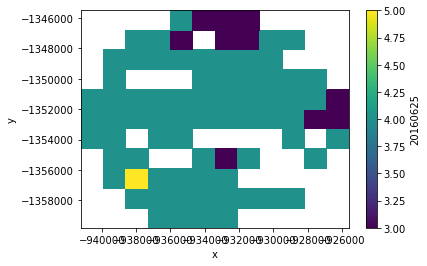

In [51]:
statsClassData1['20160625'].plot()

**export xarray dataset to a proper netcdf file, based on Robbie's notebook example**

In [65]:
import numpy as np
from datacube.drivers.netcdf import Variable, create_netcdf_storage_unit, writer as netcdf_writer
from datacube.utils.geometry import Coordinate
from datacube.utils.geometry import CRS
x_coords = netcdf_writer.netcdfy_coord(mhwData.x)
y_coords = netcdf_writer.netcdfy_coord(mhwData.y)


# Create new dataset
output_netcdf = create_netcdf_storage_unit(filename='/home/547/zxh547/dea-notebooks/CI/CI_MHW_summary.nc',
                                           
               # Set coordinate reference system 
               crs=CRS('EPSG:3577'),

               # Set up dimensions using x and y coordinates computed above
               coordinates={'x': Coordinate(x_coords, 'metres'),
                            'y': Coordinate(y_coords, 'metres')},

               # Set up empty variables for each layer, specifying the units and nodata
               variables={'noDays': Variable(dtype=np.dtype('float64'),
                                          nodata=-9999,
                                          dims=('y', 'x'),
                                          units='day'),
                          'noEvents': Variable(dtype=np.dtype('float64'),
                                                     nodata=-9999,
                                                     dims=('y', 'x'),
                                                     units='event'),
                          'totalIntensity': Variable(dtype=np.dtype('float64'),
                                                     nodata=-9999,
                                                     dims=('y', 'x'),
                                                     units='degree_Celsius days'),
                          'overallIntensity': Variable(dtype=np.dtype('float64'),
                                                     nodata=-9999,
                                                     dims=('y', 'x'),
                                                     units='degree_Celsius/day'),
                          'highestIntensity': Variable(dtype=np.dtype('float64'),
                                           nodata=-9999,
                                           dims=('y', 'x'),
                                           units='degree_Celsius'),
                          'largestDuration': Variable(dtype=np.dtype('float64'),
                                                     nodata=-9999,
                                                     dims=('y', 'x'),
                                                     units='day'),
                          'largestMeanIntensity': Variable(dtype=np.dtype('float64'),
                                                     nodata=-9999,
                                                     dims=('y', 'x'),
                                                     units='degree_Celsius/day'),
                          'largestCumIntensity': Variable(dtype=np.dtype('float64'),
                                                     nodata=-9999,
                                                     dims=('y', 'x'),
                                                     units='degree_Celsius days'),
                          'moderate': Variable(dtype=np.dtype('float64'),
                                                     nodata=-9999,
                                                     dims=('y', 'x'),
                                                     units='day'),
                          'strong': Variable(dtype=np.dtype('float64'),
                                                     nodata=-9999,
                                                     dims=('y', 'x'),
                                                     units='day'),
                          'severe': Variable(dtype=np.dtype('float64'),
                                                     nodata=-9999,
                                                     dims=('y', 'x'),
                                                     units='day'),
                          'extreme': Variable(dtype=np.dtype('float64'),
                                                     nodata=-9999,
                                                     dims=('y', 'x'),
                                                     units='day')},

               # This can be used to specify optional NetCDF creation options like compression
                variable_params={'dem': {}})

print(output_netcdf)


# noDays: assign data and set variable attributes
output_netcdf['noDays'][:] = netcdf_writer.netcdfy_data(mhwData.noDays)
output_netcdf['noDays'].standard_name = 'number_of_mhw_days'
output_netcdf['noDays'].coverage_content_type = 'MODIS MHW Study Result'
output_netcdf['noDays'].long_name = 'The total number of MHW days identified from the daily MODIS SST data'

# noEvents: assign data and set variable attributes
output_netcdf['noEvents'][:] = netcdf_writer.netcdfy_data(mhwData.noEvents)
output_netcdf['noEvents'].standard_name = 'number_of_mhw_events'
output_netcdf['noEvents'].coverage_content_type = 'MODIS MHW Study Result'
output_netcdf['noEvents'].long_name = 'The total number of MHW events identified from the daily MODIS SST data'

# totalIntensity: assign data and set variable attributes
output_netcdf['totalIntensity'][:] = netcdf_writer.netcdfy_data(mhwData.totalIntensity)
output_netcdf['totalIntensity'].standard_name = 'total_intensity_of_mhw_events'
output_netcdf['totalIntensity'].coverage_content_type = 'MODIS MHW Study Result'
output_netcdf['totalIntensity'].long_name = 'The total accumulated MHW intensity across all MHW days identified from the daily MODIS SST data'

# overallIntensity: assign data and set variable attributes
output_netcdf['overallIntensity'][:] = netcdf_writer.netcdfy_data(mhwData.overallIntensity)
output_netcdf['overallIntensity'].standard_name = 'overall_intensity_of_mhw_events'
output_netcdf['overallIntensity'].coverage_content_type = 'MODIS MHW Study Result'
output_netcdf['overallIntensity'].long_name = 'The overall (mean) MHW intensity across all MHW days identified from the daily MODIS SST data'

# highestIntensity: assign data and set variable attributes
output_netcdf['highestIntensity'][:] = netcdf_writer.netcdfy_data(mhwData.highestIntensity)
output_netcdf['highestIntensity'].standard_name = 'highest_mhw_intensity'
output_netcdf['highestIntensity'].coverage_content_type = 'MODIS MHW Study Result'
output_netcdf['highestIntensity'].long_name = 'The highest MHW intensity identified from the daily MODIS SST data'

# largestDuration: assign data and set variable attributes
output_netcdf['largestDuration'][:] = netcdf_writer.netcdfy_data(mhwData.largestDuration)
output_netcdf['largestDuration'].standard_name = 'largest_duration_of_mhw_events'
output_netcdf['largestDuration'].coverage_content_type = 'MODIS MHW Study Result'
output_netcdf['largestDuration'].long_name = 'The duration of the MHW event with the largest duration identified from the daily MODIS SST data'

# largestMeanIntensity: assign data and set variable attributes
output_netcdf['largestMeanIntensity'][:] = netcdf_writer.netcdfy_data(mhwData.largestMeanIntensity)
output_netcdf['largestMeanIntensity'].standard_name = 'largest_mean_intensity_of_mhw_events'
output_netcdf['largestMeanIntensity'].coverage_content_type = 'MODIS MHW Study Result'
output_netcdf['largestMeanIntensity'].long_name = 'The mean intensity of the MHW event with the largest mean intensity identified from the daily MODIS SST data'

# largestCumIntensity: assign data and set variable attributes
output_netcdf['largestCumIntensity'][:] = netcdf_writer.netcdfy_data(mhwData.largestCumIntensity)
output_netcdf['largestCumIntensity'].standard_name = 'largest_cumulative_intensity_of_mhw_events'
output_netcdf['largestCumIntensity'].coverage_content_type = 'MODIS MHW Study Result'
output_netcdf['largestCumIntensity'].long_name = 'The cumulative intensity of the MHW event with the largest cumulative intensity identified from the daily MODIS SST data'

# moderate: assign data and set variable attributes
output_netcdf['moderate'][:] = netcdf_writer.netcdfy_data(mhwData.moderate)
output_netcdf['moderate'].standard_name = 'moderate_mhw_events'
output_netcdf['moderate'].coverage_content_type = 'MODIS MHW Study Result'
output_netcdf['moderate'].long_name = 'The number of moderate MHW days identified from the daily MODIS SST data'

# strong: assign data and set variable attributes
output_netcdf['strong'][:] = netcdf_writer.netcdfy_data(mhwData.strong)
output_netcdf['strong'].standard_name = 'strong_mhw_events'
output_netcdf['strong'].coverage_content_type = 'MODIS MHW Study Result'
output_netcdf['strong'].long_name = 'The number of strong MHW days identified from the daily MODIS SST data'

# severe: assign data and set variable attributes
output_netcdf['severe'][:] = netcdf_writer.netcdfy_data(mhwData.severe)
output_netcdf['severe'].standard_name = 'severe_mhw_events'
output_netcdf['severe'].coverage_content_type = 'MODIS MHW Study Result'
output_netcdf['severe'].long_name = 'The number of severe MHW days identified from the daily MODIS SST data'

# extreme: assign data and set variable attributes
output_netcdf['extreme'][:] = netcdf_writer.netcdfy_data(mhwData.extreme)
output_netcdf['extreme'].standard_name = 'extreme_mhw_events'
output_netcdf['extreme'].coverage_content_type = 'MODIS MHW Study Result'
output_netcdf['extreme'].long_name = 'The number of extreme MHW days identified from the daily MODIS SST data'
        
# The `variables` method lets you verify the data has been included in the dataset:
print(output_netcdf.variables)

# Add global attributes
output_netcdf.title = 'MODIS MHW Summary Statistics'
output_netcdf.institution = 'Commonwealth of Australia (Geoscience Australia)'
output_netcdf.product_version = '0.1.0'
output_netcdf.license = 'CC BY Attribution 4.0 International License'
output_netcdf.time_coverage_start = '2002-07-04'
output_netcdf.time_coverage_end = '2019-07-22'
output_netcdf.cdm_data_type = 'Grid'
output_netcdf.contact = 'clientservices@ga.gov.au'
output_netcdf.publisher_email = 'earth.observation@ga.gov.au'
output_netcdf.source = 'OTPS TPX08 Atlas'
output_netcdf.keywords = 'MODIS, SST, MHW'
output_netcdf.summary = "Insert a detailed multiparagraph description of the dataset here"
                        
# When you print the dataset now, the new global attributes should appear:
print(output_netcdf)

# Close dataset
output_netcdf.close()

RuntimeError: Storage Unit already exists: /home/547/zxh547/dea-notebooks/CI/CI_MHW_summary.nc

In [458]:
!compliance-checker /home/547/zxh547/dea-notebooks/CI/CI_MHW_summary.nc

Running Compliance Checker on the datasets from: ['/home/547/zxh547/dea-notebooks/CI/CI_MHW_summary.nc']


--------------------------------------------------------------------------------
                         IOOS Compliance Checker Report                         
                                    acdd:1.3                                    
http://wiki.esipfed.org/index.php?title=Category:Attribute_Conventions_Dataset_Discovery
--------------------------------------------------------------------------------
                               Corrective Actions                               
CI_MHW_summary.nc has 4 potential issues


                                  Recommended                                   
--------------------------------------------------------------------------------
Global Attributes
* acknowledgment/acknowledgement not present
* comment not present
* creator_name not present
* creator_url not present
* creator_email not present
* geospatial_vertical_min no

In [234]:
data

<xarray.Dataset>
Dimensions:  (time: 6214, x: 12, y: 13)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * y        (y) float64 -1.345e+06 -1.346e+06 ... -1.359e+06 -1.36e+06
  * x        (x) float64 -9.406e+05 -9.392e+05 ... -9.276e+05 -9.262e+05
Data variables:
    sst      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

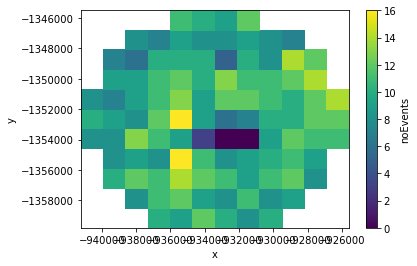

In [52]:
mhwData.noEvents.plot()

**plot the summary statistics as maps**

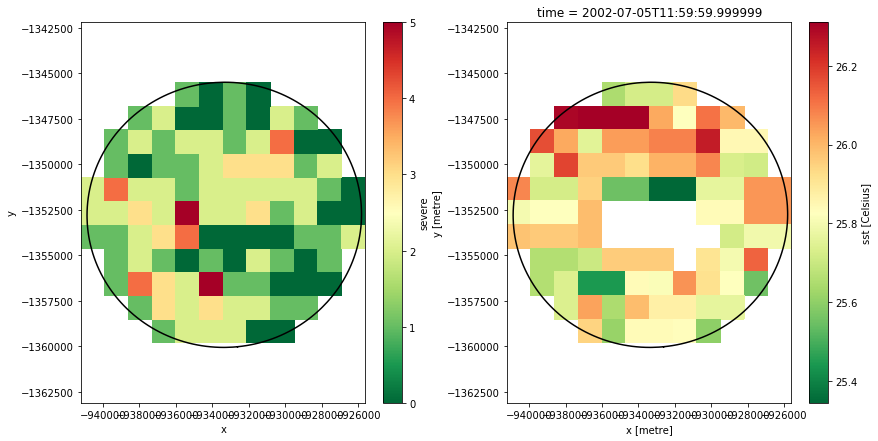

In [53]:
#plot polygon to check it looks ok

import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
for shape in LH.shapeRecords():
    
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.axis('equal')
mhwData.severe.plot(cmap='RdYlGn_r')
#data.sst[1].plot(cmap='RdYlGn_r')


plt.subplot(1,2,2)
for shape in LH.shapeRecords():
    
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.axis('equal')

data.sst[1].plot(cmap='RdYlGn_r')
plt.show()

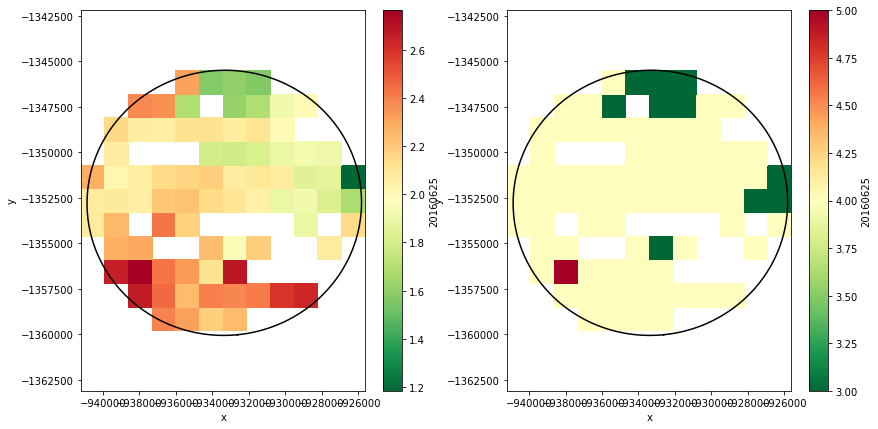

In [55]:
#plot polygon to check it looks ok

import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
fig = plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
for shape in LH.shapeRecords():
    
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.axis('equal')
statsData1['20160625'].plot(cmap='RdYlGn_r')
#data.sst[1].plot(cmap='RdYlGn_r')


plt.subplot(1,2,2)
for shape in LH.shapeRecords():
    
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.axis('equal')

statsClassData1['20160625'].plot(cmap='RdYlGn_r')
plt.show()
#plt.savefig('/home/547/zxh547/dea-notebooks/CI/test.png')
#plt.close(fig)

**Display the summary statistics as maps**

In [63]:
from ipywidgets import HBox, VBox, Button
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as ex

tempDF = pd.DataFrame()
seasons = seasonDF4.index.values
areasP = seasonDF4['count'].values / seasonDF4['observed1'].values * 100
#areas[np.isnan(areas)]=0
meanIntensities = seasonDF4['mean'].values
#meanIntensities[np.isnan(meanIntensities)]=0
tempDF['season'] = seasons
tempDF['Percent_area'] = areasP
tempDF['mean'] = meanIntensities

#f1 = go.FigureWidget(data=[go.Bar(x=seasons,y=areas,marker_color=meanIntensities,showlegend=True)])
#f1 = go.FigureWidget(data=[ex.bar(data_frame=tempDF,x='season',y='area',color='mean')])
fig1 = ex.bar(tempDF,x='season',y='Percent_area',color='mean',
              title='Observed MHW area (bar) and mean MHW intensity (color); seasonal time-series', 
              labels={'Percent_area':'Percentage of the Observed Area affected by the MHWs (%)'})
f1 = go.FigureWidget(fig1)
bar1 = f1.data[0]
#f1

tempDF1 = pd.DataFrame()
dateL = ['xx']
areaL = [0.0]
intensityL = [0.0]
tempDF1['date'] = dateL
tempDF1['Percent_area'] = areaL
tempDF1['mean'] = intensityL
#f2 = go.FigureWidget(data=[go.Bar(x=dateL,y=intensityL,marker_color=intensityL)])
fig2 = ex.bar(tempDF1,x='date',y='Percent_area',color='mean',
              title='Observed MHW area (bar) and mean MHW intensity (color); daily time-series',
             labels={'Percent_area':'Percentage of the Observed Area affected by the MHWs (%)'})
f2 = go.FigureWidget(fig2)
bar2 = f2.data[0]
#f2

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in true_divide



In [165]:
from ipywidgets import HBox, VBox, Button
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as ex

tempDF = pd.DataFrame()
seasons = seasonDF4.index.values
areasP = seasonDF4['count'].values / seasonDF4['observed1'].values * 100
mhwDays = seasonDF4['mhwDays'].values
meanIntensities = seasonDF4['mean'].values

tempDF['season'] = seasons
tempDF['Percent_area'] = areasP
tempDF['mean'] = meanIntensities

#f1 = go.FigureWidget(data=[go.Bar(x=seasons,y=areas,marker_color=meanIntensities,showlegend=True)])
#f1 = go.FigureWidget(data=[ex.bar(data_frame=tempDF,x='season',y='area',color='mean')])

fig1 = make_subplots(specs=[[{"secondary_y": True}]])
fig1.add_trace(go.Bar(x=seasons,y=areasP,marker=dict(color=meanIntensities,colorscale='Rainbow',
                                                     showscale=True,colorbar=dict(title='oC')),name='mean intensity',showlegend=False),secondary_y=False)

fig1.add_trace(go.Scatter(x=seasons,y=mhwDays,mode='markers',marker=dict(color='black'),name='mhwDays',showlegend=False),secondary_y=True)
fig1.update_yaxes(title_text='Number of MHW days',rangemode='tozero',range=[0,100],secondary_y=True)
fig1.update_yaxes(title_text='Percentage of the Observed Area affected by the MHWs (%)',rangemode='tozero',range=[0,100],secondary_y=False)
fig1.update_layout(title_text="Observed MHW area (bar,left axis), number of MHW days (solid circle, right axis) and mean MHW intensity (color); seasonal time-series")
f1 = go.FigureWidget(fig1)
bar1 = f1.data[0]
marker1 = f1.data[1]
#f1.show()

tempDF1 = pd.DataFrame()
dateL = ['xx']
areaL = [0.0]
intensityL = [0.0]
tempDF1['date'] = dateL
tempDF1['Percent_area'] = areaL
tempDF1['mean'] = intensityL
#f2 = go.FigureWidget(data=[go.Bar(x=dateL,y=intensityL,marker_color=intensityL)])
fig2 = ex.bar(tempDF1,x='date',y='Percent_area',color='mean',
              title='Observed MHW area (bar) and mean MHW intensity (color); daily time-series',
             labels={'Percent_area':'Percentage of the Observed Area affected by the MHWs (%)'})
f2 = go.FigureWidget(fig2)
bar2 = f2.data[0]
#f2

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in true_divide



In [166]:

def displaySeason(trace,points,state):
    #global dates, intensities
    dates = []
    areas = []
    intensities = []
    dateL = []
    print(points.point_inds)
    season = bar1.x[points.point_inds]    
    print(season)
    #print(dates)
    if season == '2016 winter':
        
        winter2016 = statsDF4.loc['20160601':'20160831']
        dates = winter2016.index.values
        areas = winter2016['count'].values / winter2016['observed'] * 100
        intensities = winter2016['mean'].values
        #print(intensities)
        for date in dates:
            year = date[0:4]
            month = date[4:6]
            dat = date[6:8]
            dateL.append(year+'-'+month+dat)
    
    bar2.x = dateL
    bar2.y = areas
    bar2.marker.color = intensities

def displaySeason1(trace,points,state):
    #global dates, intensities
    dates = []
    areas = []
    intensities = []
    dateL = []
    print(points.point_inds)
    season1 = marker1.x[points.point_inds]
    print(season1)
    #print(dates)
    if season1 == '2016 winter':
        
        winter2016 = statsDF4.loc['20160601':'20160831']
        dates = winter2016.index.values
        areas = winter2016['count'].values / winter2016['observed'] * 100
        intensities = winter2016['mean'].values
        #print(intensities)
        for date in dates:
            year = date[0:4]
            month = date[4:6]
            dat = date[6:8]
            dateL.append(year+'-'+month+dat)
    
    bar2.x = dateL
    bar2.y = areas
    bar2.marker.color = intensities

from PIL import Image
def displayDay(trace,points,state):
    
    date = bar2.x[points.point_inds[0]]
    date = date[0:4]+date[5:9]
    
    poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
    LH = shpf.Reader(poly_path)
    fig = plt.figure(figsize=(10,10))

    for shape in LH.shapeRecords():

        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
    plt.axis('equal')
    statsData1[date].plot(cmap='RdYlGn_r')
    figName = date+".png"
    plt.savefig("/home/547/zxh547/dea-notebooks/CI/" + figName)
    plt.close(fig)
    img1 = Image.open("/home/547/zxh547/dea-notebooks/CI/" + figName)
    img1.show()
                      
    
    
bar1.on_click(displaySeason)
marker1.on_selection(displaySeason1)
bar2.on_click(displayDay)



In [167]:
#dashboard = VBox([HBox([f1, f2])])
dashboard = VBox([f1, f2])
dashboard

    'data': [{'marker': {'color': array([       nan,        nan,        nan,    …

[56]
['2016 winter']
[]
[]


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]
['2002 winter' '2002 spring' '2002-03 summer' '2003 autumn' '2003 winter'
 '2003 spring' '2003-04 summer' '2004 autumn' '2004 winter' '2004 spring'
 '2004-05 summer' '2005 autumn' '2005 winter' '2005 spring'
 '2005-06 summer' '2006 autumn' '2006 winter' '2006 spring'
 '2006-07 summer' '2007 autumn' '2007 winter' '2007 spring'
 '2007-08 summer' '2008 autumn' '2008 winter' '2008 spring'
 '2008-09 summer' '2009 autumn' '2009 winter' '2009 spring'
 '2009-10 summer' '2010 autumn' '2010 winter' '2010 spring'
 '2010-11 summer' '2011 autumn' '2011 winter' '2011 spring'
 '2011-12 summer' '2012 autumn' '2012 winter' '2012 spring'
 '2012-13 summer' '2013 autumn' '2013 winter' '2013 spring'
 '2013-14 summer' '2014 autumn' '2014 winter' '20

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

[56]
['2016 winter']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]
['2002 winter' '2002 spring' '2002-03 summer' '2003 autumn' '2003 winter'
 '2003 spring' '2003-04 summer' '2004 autumn' '2004 winter' '2004 spring'
 '2004-05 summer' '2005 autumn' '2005 winter' '2005 spring'
 '2005-06 summer' '2006 autumn' '2006 winter' '2006 spring'
 '2006-07 summer' '2007 autumn' '2007 winter' '2007 spring'
 '2007-08 summer' '2008 autumn' '2008 winter' '2008 spring'
 '2008-09 summer' '2009 autumn' '2009 winter' '2009 spring'
 '2009-10 summer' '2010 autumn' '2010 winter' '2010 spring'
 '2010-11 summer' '2011 autumn' '2011 winter' '2011 spring'
 '2011-12 summer' '2012 autumn' '2012 winter' '2012 spring'
 '2012-13 summer' '2013 autumn' '2013 winter' '2013 spring'
 '2013-14 summer' '2014 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

[56]
['2016 winter']
[]
[]


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[56, 57]
['2016 winter' '2016 spring']


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

[56]
['2016 winter']
[]
[]


/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



[56]
['2016 winter']


In [134]:
from ipywidgets import HBox, VBox, Button
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as ex

tempDF = pd.DataFrame()
seasons = seasonDF4.index.values
areasP = seasonDF4['count'].values / seasonDF4['observed1'].values * 100
mhwDays = seasonDF4['mhwDays'].values
meanIntensities = seasonDF4['mean'].values

tempDF['season'] = seasons
tempDF['Percent_area'] = areasP
tempDF['mean'] = meanIntensities

#f1 = go.FigureWidget(data=[go.Bar(x=seasons,y=areas,marker_color=meanIntensities,showlegend=True)])
#f1 = go.FigureWidget(data=[ex.bar(data_frame=tempDF,x='season',y='area',color='mean')])

fig1 = make_subplots(specs=[[{"secondary_y": True}]])
fig1.add_trace(go.Bar(x=seasons,y=areasP,marker=dict(color=meanIntensities,colorscale='Rainbow',
                                                     showscale=True,colorbar=dict(title='oC')),showlegend=False),secondary_y=False)

fig1.add_trace(go.Scatter(x=seasons,y=mhwDays,mode='markers',marker=dict(color='black'),name='mhwDays',showlegend=False),secondary_y=True)
fig1.update_yaxes(title_text='Number of MHW days',rangemode='tozero',range=[0,100],secondary_y=True)
fig1.update_yaxes(title_text='Percentage of the Observed Area affected by the MHWs (%)',rangemode='tozero',range=[0,100],secondary_y=False)
fig1.update_layout(title_text="Observed MHW area (bar,left axis), number of MHW days (solid circle, right axis) and mean MHW intensity (color); seasonal time-series")
f1 = go.FigureWidget(fig1)
bar1 = f1.data[0]
f1.show()

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in true_divide



In [112]:
bar1.x

array(['2002 winter', '2002 spring', '2002-03 summer', '2003 autumn',
       '2003 winter', '2003 spring', '2003-04 summer', '2004 autumn',
       '2004 winter', '2004 spring', '2004-05 summer', '2005 autumn',
       '2005 winter', '2005 spring', '2005-06 summer', '2006 autumn',
       '2006 winter', '2006 spring', '2006-07 summer', '2007 autumn',
       '2007 winter', '2007 spring', '2007-08 summer', '2008 autumn',
       '2008 winter', '2008 spring', '2008-09 summer', '2009 autumn',
       '2009 winter', '2009 spring', '2009-10 summer', '2010 autumn',
       '2010 winter', '2010 spring', '2010-11 summer', '2011 autumn',
       '2011 winter', '2011 spring', '2011-12 summer', '2012 autumn',
       '2012 winter', '2012 spring', '2012-13 summer', '2013 autumn',
       '2013 winter', '2013 spring', '2013-14 summer', '2014 autumn',
       '2014 winter', '2014 spring', '2014-15 summer', '2015 autumn',
       '2015 winter', '2015 spring', '2015-16 summer', '2016 autumn',
       '2016 winter'

In [169]:
from osgeo import gdal
from osgeo import osr
srs = osr.SpatialReference()
srs.ImportFromEPSG(32755)
srs.ExportToPrettyWkt()

'PROJCS["WGS 84 / UTM zone 55S",\n    GEOGCS["WGS 84",\n        DATUM["WGS_1984",\n            SPHEROID["WGS 84",6378137,298.257223563,\n                AUTHORITY["EPSG","7030"]],\n            AUTHORITY["EPSG","6326"]],\n        PRIMEM["Greenwich",0,\n            AUTHORITY["EPSG","8901"]],\n        UNIT["degree",0.0174532925199433,\n            AUTHORITY["EPSG","9122"]],\n        AUTHORITY["EPSG","4326"]],\n    PROJECTION["Transverse_Mercator"],\n    PARAMETER["latitude_of_origin",0],\n    PARAMETER["central_meridian",147],\n    PARAMETER["scale_factor",0.9996],\n    PARAMETER["false_easting",500000],\n    PARAMETER["false_northing",10000000],\n    UNIT["metre",1,\n        AUTHORITY["EPSG","9001"]],\n    AXIS["Easting",EAST],\n    AXIS["Northing",NORTH],\n    AUTHORITY["EPSG","32755"]]'

In [170]:
import os
'GDAL_DATA' in os.environ

True

In [171]:
os.environ

environ{'CPLUS_INCLUDE_PATH': '/apps/udunits/2.1.24/include',
        'MODULE_VERSION_STACK': '3.2.10',
        'PROJ_LIB': '/g/data/v10/public/modules/dea-env/20190709/share/proj',
        'ORBIT_SOCKETDIR': '/local/v10/zxh547/tmp/orbit-zxh547',
        'MANPATH': '/apps/udunits/2.1.24/share/man:/opt/pbs/default/share/man:/usr/local/share/man:/usr/share/man:/usr/X11R6/man:/opt/man:/opt/puppetlabs/puppet/share/man',
        'VNCDESKTOP': 'vdi-n19:1 (zxh547)',
        'SSH_AGENT_PID': '1030',
        'HOSTNAME': 'vdi-n19',
        'GIO_LAUNCHED_DESKTOP_FILE_PID': '1474',
        'NF_MODULES_LOADED': 'YES',
        'TERM': 'xterm-color',
        'SHELL': '/bin/bash',
        'XDG_SESSION_COOKIE': '637e117766230d9d6cc62f0300000082-1575235063.143017-815361487',
        'PROJECT': 'v10',
        'TMPDIR': '/local/v10/zxh547/tmp',
        'LIBRARY_PATH': '/apps/udunits/2.1.24/lib',
        'GTK_RC_FILES': '/etc/gtk/gtkrc:/home/547/zxh547/.gtkrc-1.2-gnome2',
        'WINDOWID': '37748739',
  